# Cornell Movie Dialog Dataset
Collection of conversations extracted from movie scripts, created by researchers at *Cornell University*

- Website: https://www.cs.cornell.edu/~cristian/Chameleons_in_imagined_conversations.html

- Dataset: http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip

- Paper: https://www.cs.cornell.edu/~cristian/papers/chameleons.pdf

**Citation:**
>Danescu-Niculescu-Mizil, C., & Lee, L. (2011).
>
> *Chameleons in imagined conversations: A new approach to understanding coordination of linguistic style in dialogs.*
>
> In Proceedings of the Workshop on Cognitive Modeling and Computational Linguistics, ACL 2011.



**NLP Group Assignment**
- Elif Gamze GULITER
- Romane KULESZA
- Volkan MAZLUM
- Juan Pablo RAMIREZ

**Politecnico di Milano**

The purpose of this notebook is to ...

### Connect to Drive
**(optional for Google Colab users)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/NLP Cornell Movie Dataset/

Mounted at /content/drive/
/content/drive/My Drive/NLP Cornell Movie Dataset


### Download and unzip the Cornell Movie Dialog dataset
**(optional)**

In [ ]:
# Download and unzip the Cornell Movie Dialog dataset
download = False
if download:
  !curl -L -o cornell_movie_dialogs.zip http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
  !unzip cornell_movie_dialogs.zip

### Import Libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
!pip install -q python-terrier
#!pip install --upgrade git+https://github.com/terrier-org/pyterrier.git
!pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.p

In [ ]:
# Import NLP libraries
import re
import string

# NLTK
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.util import ngrams
from nltk.tag import pos_tag

from collections import Counter

# PyTerrier
import pyterrier as pt
if not pt.started():
  pt.init()

# Gensim
from gensim.models.word2vec import Word2Vec
from gensim.models import FastText
import gensim.downloader as gensim_downloader

# scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


terrier-assemblies 5.9 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.10.1 has loaded Terrier 5.9 (built by craigm on 2024-05-02 17:40) and terrier-helper 0.0.8



In [ ]:
# Import other libraries
import ast
import pandas as pd
from scipy.stats import ttest_ind
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rc('font', size=12)

### Text files inspection

First, we must visualize the content of each text file of the dataset in order to appropriately map them onto a data structure for subsequent analysis and manipulation within our NLP pipeline.

In [ ]:
# Dataset folder name (change it in case the dataset folder name is different)
DATASET_FOLDER = 'cornell movie-dialogs corpus'

In [ ]:
def inspect_txt(txt_filename, dataset_folder=DATASET_FOLDER, n=5):
  '''
  Function to inspect the first n lines of a text file
  params:
  - txt_filename (str): The name of the text file to inspect
  - base_path (str): The base path where the text file is located
  - lines (int): The number of lines to print from the text file. Default is 5.
  '''
  with open(os.path.join(os.getcwd(), dataset_folder, txt_filename), "r", encoding="iso-8859-1") as file:
    total_lines = 0
    for line in file:
      total_lines += 1
      if total_lines < n: print(line)
    print(f'...\nTotal lines: {total_lines}')

In [ ]:
# movie_title.txt
inspect_txt('movie_titles_metadata.txt')

m0 +++$+++ 10 things i hate about you +++$+++ 1999 +++$+++ 6.90 +++$+++ 62847 +++$+++ ['comedy', 'romance']

m1 +++$+++ 1492: conquest of paradise +++$+++ 1992 +++$+++ 6.20 +++$+++ 10421 +++$+++ ['adventure', 'biography', 'drama', 'history']

m2 +++$+++ 15 minutes +++$+++ 2001 +++$+++ 6.10 +++$+++ 25854 +++$+++ ['action', 'crime', 'drama', 'thriller']

m3 +++$+++ 2001: a space odyssey +++$+++ 1968 +++$+++ 8.40 +++$+++ 163227 +++$+++ ['adventure', 'mystery', 'sci-fi']

...
Total lines: 617


The file named *movie_title.txt* encompasses 617 lines, each detailing information regarding movies (identifier, title, release year, IMBD rating, number of IMBD votes, and genres).

The format of each line follows a structured pattern:

\<movie_id> +++\$+++ \<movie_title> +++\$+++ \<movie_year> +++\$+++ \<movie_IMBD_rating> +++\$+++ \<movie_IMDB_votes> +++\$+++ \<movie_genres>

In [ ]:
# raw_script_urls.txt
inspect_txt('raw_script_urls.txt')

m0 +++$+++ 10 things i hate about you +++$+++ http://www.dailyscript.com/scripts/10Things.html

m1 +++$+++ 1492: conquest of paradise +++$+++ http://www.hundland.org/scripts/1492-ConquestOfParadise.txt

m2 +++$+++ 15 minutes +++$+++ http://www.dailyscript.com/scripts/15minutes.html

m3 +++$+++ 2001: a space odyssey +++$+++ http://www.scifiscripts.com/scripts/2001.txt

...
Total lines: 617


The file named *raw_script_urls.txt* contains 617 lines, each with information regarding movie url references (movie identifier, mvie name, and reference url).

The format of each line follows a structured pattern:

\<movie_id> +++\$+++ \<movie_name> +++\$+++ \<url>

In [ ]:
# movie_characters_metadata.txt
inspect_txt('movie_characters_metadata.txt')

u0 +++$+++ BIANCA +++$+++ m0 +++$+++ 10 things i hate about you +++$+++ f +++$+++ 4

u1 +++$+++ BRUCE +++$+++ m0 +++$+++ 10 things i hate about you +++$+++ ? +++$+++ ?

u2 +++$+++ CAMERON +++$+++ m0 +++$+++ 10 things i hate about you +++$+++ m +++$+++ 3

u3 +++$+++ CHASTITY +++$+++ m0 +++$+++ 10 things i hate about you +++$+++ ? +++$+++ ?

...
Total lines: 9035


The file named *movie_characters_metadata.txt* encompasses 9035 lines, each containing data regarding movie characters (identifier, name, movie identifier, movie name, gender, and position in credits).

The format of each line follows a structured pattern:

\<character_id> +++\$+++ \<character_name> +++\$+++ \<movie_id> +++\$+++ \<movie_title> +++\$+++ \<character_gender> +++\$+++ \<character_pos_credits>

In [ ]:
# movie_lines.txt
inspect_txt('movie_lines.txt')

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!

L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!

L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.

L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?



The file named *movie_lines.txt* encompasses 304713 lines, each with information regarding movie line utterances (identifier, character identifier, movie identifier, character name, and text).

The format of each line follows a structured pattern:

\<utterance_id> +++\$+++ \<character_id> +++\$+++ \<movie_id> +++\$+++ \<character_name>+++\$+++ \<text>

In [ ]:
# movie_conversations.txt
inspect_txt('movie_conversations.txt')

The file named *movie_conversations.txt* contains 83097 lines, each with data regarding movie conversations (first character identifier, second character identifier, movie identifier, and list of line identifiers).

The format of each line follows a structured pattern:

\<character1_id> +++\$+++ \<character2_id> +++\$+++ \<movie_id> +++\$+++ \<line_identifiers>

### Load Cornell Movie Dialog Dataset

Following the examination of the .txt files, we proceed to ingest all data into structured Python dictionaries, facilitating convenient storage and access of the dataset.

In [ ]:
class CornellMovieDialogDataset:
  """
  Class to represent the Cornell Movie Dialog Dataset.

  Attributes:
    - base_path (str): The base path where the dataset files are located.
    - movies (dict): A dictionary to store movie metadata (indexed by movie ID).
        - title
        - year
        - IMBD_rating
        - IMBD_votes
        - genres
        - url
    - characters (dict): A dictionary to store character metadata (indexed by character ID).
        - name
        - movie_id
        - gender
        - pos_credits
    - utterances (dict): A dictionary to store movie lines (indexed by utterance ID).
        - character_id
        - movie_id
        - text
    - conversations (list): A list to store conversation data (represented as a list of utterance IDs).
  """
  def __init__(self, base_path):
    self.base_path = base_path
    self.movies = {}
    self.characters = {}
    self.utterances = {}
    self.conversations = []
    self.load_data()

  def load_data(self):
    """
    Loads the data from the dataset files into the class attributes.
    Uses original iso-8859-1 encoding of the dataset to read files
    """
    # Load movie titles
    with open(os.path.join(self.base_path, "movie_titles_metadata.txt"), "r", encoding="iso-8859-1") as file:
      for line in file:
        parts = [part.strip() for part in line.split("+++$+++")]
        self.movies[parts[0]] = {
            'title': parts[1],
            'year': int(re.match('\d+', parts[2])[0]),
            'IMDB_rating': float(re.match('[-+]?\d*\.\d+', parts[3])[0]),
            'IMDB_votes': int(re.match('\d+', parts[4])[0]),
            'genres': ast.literal_eval(parts[5])
        }

    # Load movie URL references
    with open(os.path.join(self.base_path, "raw_script_urls.txt"), "r", encoding="iso-8859-1") as file:
      for line in file:
        parts = [part.strip() for part in line.split("+++$+++")]
        self.movies[parts[0]]['url'] = parts[-1]

    # Load characters
    with open(os.path.join(self.base_path, "movie_characters_metadata.txt"), "r", encoding="iso-8859-1") as file:
      for line in file:
        parts = [part.strip() for part in line.split("+++$+++")]
        self.characters[parts[0]] = {
            'name': parts[1],
            'movie_id': parts[2],
            # ignore movie title (redundant)
            'gender': parts[4].lower(),
            'pos_credits': parts[5]
        }

    # Load movie lines
    with open(os.path.join(self.base_path, "movie_lines.txt"), "r", encoding="iso-8859-1") as file:
      for line in file:
        parts = [part.strip() for part in line.split("+++$+++")]
        self.utterances[parts[0]] = {
            'character_id': parts[1],
            'movie_id': parts[2],
            # ignore character name (redundant)
            'text': parts[4]
        }

    # Load conversations
    with open(os.path.join(self.base_path, "movie_conversations.txt"), "r", encoding="iso-8859-1") as file:
      for line in file:
        parts = [part.strip() for part in line.split("+++$+++")]
        self.conversations.append(ast.literal_eval(parts[3]))
        # ignore character ids / movie id (redundant)

  def print_summary(self):
    """
    Prints a summary of the dataset.
    """
    print(f'Number of movies: {len(self.movies)}')
    print(f'Number of characters: {len(self.characters)}')
    print(f'Number of utterances: {len(self.utterances)}')
    print(f'Number of conversations: {len(self.conversations)}')

  def print_random_conversation(self):
    """
    Prints a random conversation from the dataset.
    """
    random_conversation = random.choice(self.conversations)
    print(self.conversation_to_string(random_conversation))

  def conversation_to_string(self, conversation):
    '''
    Prints a conversation based on a list of utterance IDs.
    params:
    - conversation (list): A list of utterance IDs representing the conversation
    '''
    text = ''
    movie = self.movies[self.utterances[conversation[0]]['movie_id']]
    text += f"{movie['title']} ({movie['year']})\n"
    for line in conversation:
      text += f"{self.characters[self.utterances[line]['character_id']]['name']}: {self.utterances[line]['text']}\n"
    return text

  def get_utterance_texts_list(self):
    '''
    Function to retrieve all the dialog texts.
    returns:
    - texts (list): A list of texts of all dialogs in the dataset
    '''
    return [d['text'] for d in self.utterances.values()]

  def get_characters_by_movie(self, movie_id):
    '''
    Function to retrieve characters associated with a specific movie ID.
    params:
    - movie_id (str): The ID of the movie for which characters are to be retrieved
    returns:
    - characters (list): A list of character IDs associated with the specified movie ID
    '''
    characters = []
    for id, character in self.characters.items():
      if character['movie_id'] == movie_id:
        characters.append(id)
    return characters

  def get_utterances_by_movie(self, movie_id):
    '''
    Function to retrieve utterances associated with a specific movie ID.
    params:
    - movie_id (str): The ID of the movie for which utterance are to be retrieved
    returns:
    - utterances (list): A list of utterances IDs associated with the specified movie ID
    '''
    utterances = []
    for id, utterance in self.utterances.items():
      if utterance['movie_id'] == movie_id:
        utterances.append(id)
    return utterances

  def get_conversations_by_movie(self, movie_id):
    '''
    Function to retrieve conversations associated with a specific movie ID.
    params:
    - movie_id (str): The ID of the movie for which conversations are to be retrieved
    returns:
    - conversations (list): A list of lists of utterances IDs associated with the specified movie ID
    '''
    conversations = []
    for conversation in self.conversations:
      if self.utterances[conversation[0]]['movie_id'] == movie_id:
        conversations.append(conversation)
    return conversations

  def get_utterances_by_character(self, character_id):
    '''
    Function to retrieve utterances associated with a specific character ID.
    params:
    - character_id (str): The ID of the character for which utterance are to be retrieved
    returns:
    - utterances (list): A list of utterances IDs associated with the specified character ID
    '''
    utterances = []
    for id, utterance in self.utterances.items():
      if utterance['character_id'] == character_id:
        utterances.append(id)
    return utterances

  def get_conversations_by_character(self, character_id):
    '''
    Function to retrieve conversations associated with a specific character ID.
    params:
    - character_id (str): The ID of the character for which conversations are to be retrieved
    returns:
    - conversations (list): A list of lists of utterances IDs associated with the specified character ID
    '''
    conversations = []
    for conversation in self.conversations:
      for line in conversation:
        if self.utterances[line]['character_id'] == character_id:
          conversations.append(conversation)
          break
    return conversations


In [ ]:
# Instantiate dataset object and load data
dataset = CornellMovieDialogDataset(os.path.join(os.getcwd(), DATASET_FOLDER))

In [ ]:
dataset.print_summary()

Number of movies: 617
Number of characters: 9035
Number of utterances: 304713
Number of conversations: 83097


In [ ]:
dataset.print_random_conversation()

jfk (1991)
LOU: ...take a good look, chief, do any of 'em look like the hoboes you remember?
JIM: Hoboes I knew of old used to sleep in their clothes - these two look pretty young.
LOU: ...not a single frayed collar or cuff, new haircuts, fresh shaves, clean hands - new shoe leather. Look at the ear of the cop... That's a wire.  What's a cop wearing a headset for?  I think they're actors, chief; they're not cops.



In [ ]:
#!pip3 install convokit
#from convokit import Corpus, download
#corpus = Corpus(filename=download("movie-corpus"))
#dir(corpus)

## 1. Preliminary Analysis

### Dataset Statistics

In [ ]:
def plot_numerical_attribute(attribute_name, attribute_value):
  '''
  Function to plot the distribution of a numerical attribute.
  params:
  - attribute_name (str): The name of the attribute being plotted
  - attribute_value (list): The values of the numerical attribute to be plotted
  '''
  plt.figure(figsize=(6, 2))
  sns.displot(attribute_value, kde=True, legend=False, color='skyblue', edgecolor='black')
  plt.title(f'Distribution of {attribute_name}')
  plt.xlabel(attribute_name)
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.show()

# Function to visualize the distribution of categorical attributes
def plot_categorical_attribute(attribute_name, attribute_value):
  '''
  Function to plot a count distribution of a categorical attribute.
  It also prints the top 10 most frequent categories along with their percentages and counts.
  params:
  - attribute_name (str): The name of the categorical attribute
  - attribute_value (list): The values of the categorical attribute
  '''
  df = pd.DataFrame(attribute_value, columns=[attribute_name])
  plt.figure(figsize=(16, 2))
  sns.countplot(data=df, x=attribute_name, legend=False, order = df[attribute_name].value_counts().iloc[:20].index, color='lightgreen', edgecolor='black')
  plt.title(f'Count of {attribute_name}')
  plt.xlabel(attribute_name)
  plt.ylabel('Frequency')
  plt.yticks(fontsize=5)
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.show()
  print(pd.DataFrame(df, columns=[attribute_name]).value_counts(normalize=True).iloc[:10].mul(100).round(1).astype(str) + '%')
  print(pd.DataFrame(df, columns=[attribute_name]).value_counts().iloc[:10])

#### Movies

In [ ]:
# Transform the movies dictionary to a Pandas DataFrame
movies_df = pd.DataFrame.from_dict(dataset.movies, orient='index')
movies_df['characters'] = [len(dataset.get_characters_by_movie(id)) for id in dataset.movies.keys()]
movies_df['utterances'] = [len(dataset.get_utterances_by_movie(id)) for id in dataset.movies.keys()]
movies_df['conversations'] = [len(dataset.get_conversations_by_movie(id)) for id in dataset.movies.keys()]

<Figure size 600x200 with 0 Axes>

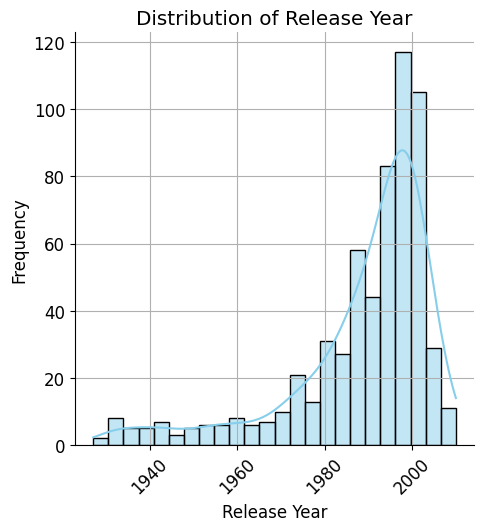

count     617.000000
mean     1988.575365
std        16.589229
min      1927.000000
25%      1984.000000
50%      1994.000000
75%      1999.000000
max      2010.000000
Name: year, dtype: float64

In [ ]:
# Visualize movie release year statistics
plot_numerical_attribute('Release Year', movies_df['year'])
movies_df['year'].describe()

<Figure size 600x200 with 0 Axes>

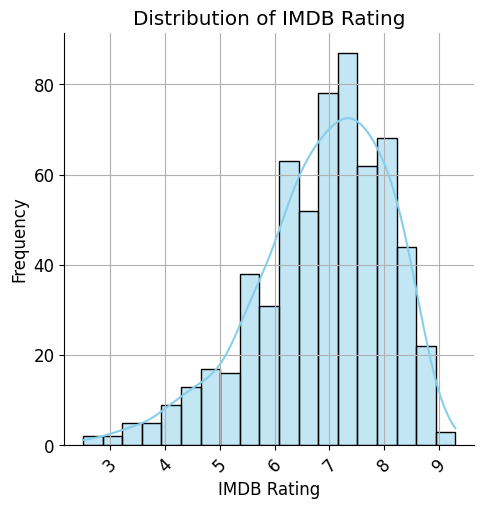

count    617.000000
mean       6.863857
std        1.215233
min        2.500000
25%        6.200000
50%        7.000000
75%        7.800000
max        9.300000
Name: IMDB_rating, dtype: float64


<Figure size 600x200 with 0 Axes>

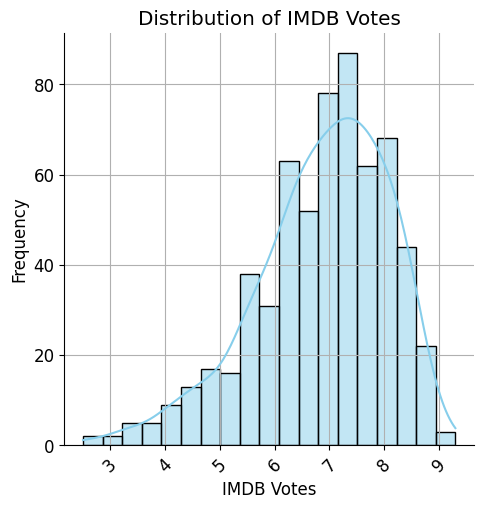

count       617.000000
mean      49820.962723
std       61880.609145
min           9.000000
25%        9919.000000
50%       27112.000000
75%       66781.000000
max      419312.000000
Name: IMDB_votes, dtype: float64


<Axes: xlabel='IMDB_rating', ylabel='IMDB_votes'>

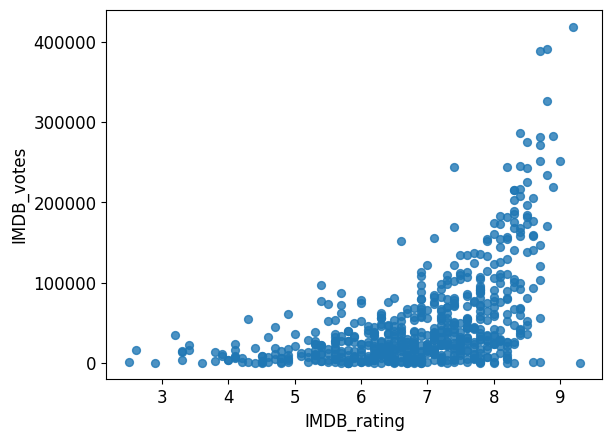

In [ ]:
# Visualize movie IMDB statistics
plot_numerical_attribute('IMDB Rating', movies_df['IMDB_rating'])
print(movies_df['IMDB_rating'].describe())
plot_numerical_attribute('IMDB Votes', movies_df['IMDB_rating'])
print(movies_df['IMDB_votes'].describe())
movies_df.plot(kind='scatter', x='IMDB_rating', y='IMDB_votes', s=32, alpha=.8)

In [ ]:
# Best movies
movies_df[movies_df['IMDB_votes'] > movies_df['IMDB_votes'].quantile(0.75)].sort_values(by=['IMDB_rating'], ascending=False).iloc[:10]

,title,year,IMDB_rating,IMDB_votes,genres,url,characters,utterances,conversations
m203,the godfather,1972,9.2,419312,"[crime, drama, thriller]","http://www.dailyscript.com/scripts/Godfather,%...",23,536,147
m369,the godfather: part ii,1974,9.0,251290,"[crime, drama, thriller]",http://www.dailyscript.com/scripts/godfather2....,32,670,143
m504,schindler's list,1993,8.9,282473,"[biography, drama, history, war]",http://www.awesomefilm.com/script/schindlersli...,13,238,80
m463,one flew over the cuckoo's nest,1975,8.9,219739,[drama],http://www.dailyscript.com/scripts/One%20Flew%...,21,702,213
m372,goodfellas,1990,8.8,234582,"[crime, drama, thriller]",http://www.dailyscript.com/scripts/goodfellas....,15,293,76
m348,fight club,1999,8.8,391697,"[crime, drama, mystery, thriller]",http://www.scifiscripts.com/scripts/fight_club...,17,779,188
m42,casablanca,1942,8.8,170874,"[drama, romance, war]",http://www.dailyscript.com/scripts/Casablanca.txt,15,834,220
m529,star wars,1977,8.8,326619,"[action, adventure, fantasy, sci-fi]",http://www.scifiscripts.com/scripts/star_wars_...,12,291,96
m433,the matrix,1999,8.7,389480,"[action, adventure, adventure, adventure, sci-fi]",http://www.scifiscripts.com/scripts/matrix_97_...,12,490,155
m167,rear window,1954,8.7,121165,"[crime, mystery, romance, thriller]",http://www.dailyscript.com/scripts/Rear+Window...,10,601,144


<Figure size 600x200 with 0 Axes>

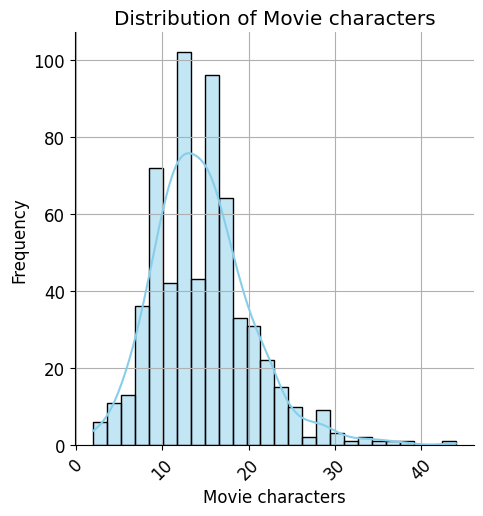

count    617.000000
mean      14.643436
std        5.629462
min        2.000000
25%       11.000000
50%       14.000000
75%       18.000000
max       44.000000
Name: characters, dtype: float64


<Figure size 600x200 with 0 Axes>

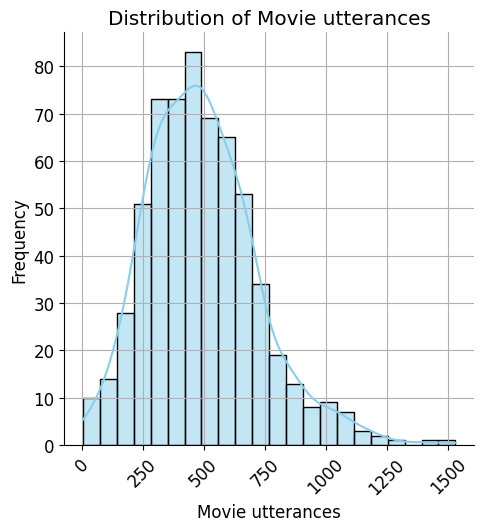

count     617.000000
mean      493.862237
std       228.206379
min         6.000000
25%       330.000000
50%       474.000000
75%       625.000000
max      1530.000000
Name: utterances, dtype: float64


<Figure size 600x200 with 0 Axes>

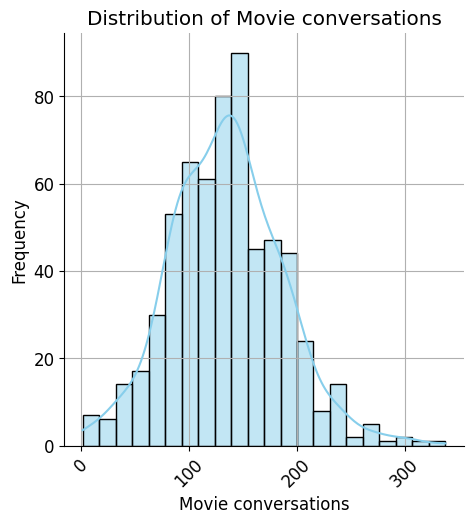

count    617.000000
mean     134.679092
std       51.629054
min        1.000000
25%       98.000000
50%      133.000000
75%      166.000000
max      338.000000
Name: conversations, dtype: float64


<Axes: xlabel='characters', ylabel='utterances'>

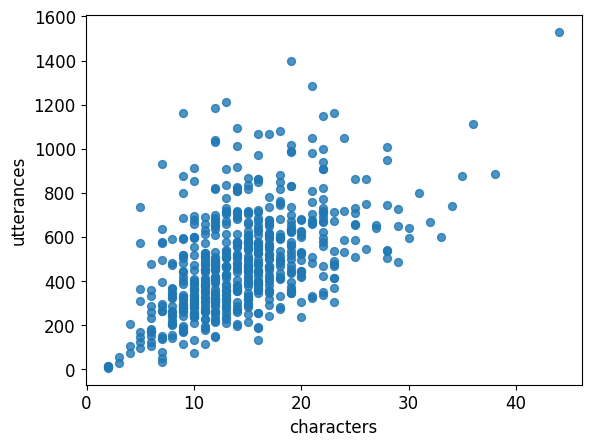

In [ ]:
# Visualize movie character utterance statistics
plot_numerical_attribute('Movie characters', movies_df['characters'])
print(movies_df['characters'].describe())
plot_numerical_attribute('Movie utterances', movies_df['utterances'])
print(movies_df['utterances'].describe())
plot_numerical_attribute('Movie conversations', movies_df['conversations'])
print(movies_df['conversations'].describe())
movies_df.plot(kind='scatter', x='characters', y='utterances', s=32, alpha=.8)

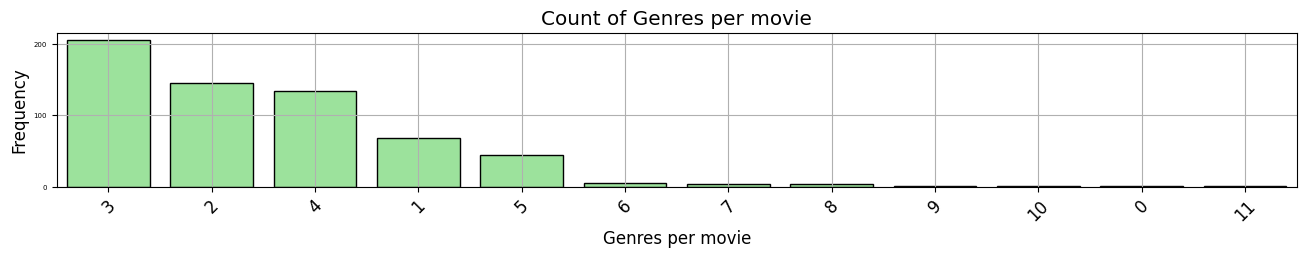

Genres per movie
3                   33.2%
2                   23.7%
4                   21.7%
1                   11.2%
5                    7.1%
6                    0.8%
7                    0.6%
8                    0.6%
9                    0.3%
10                   0.3%
Name: proportion, dtype: object
Genres per movie
3                   205
2                   146
4                   134
1                    69
5                    44
6                     5
7                     4
8                     4
9                     2
10                    2
Name: count, dtype: int64


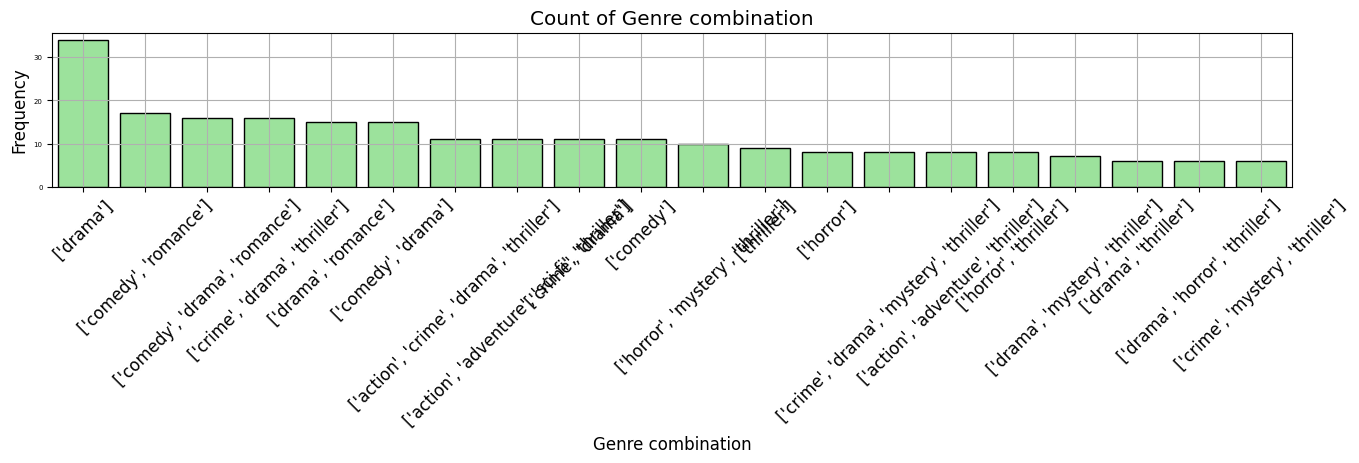

Genre combination                            
['drama']                                        5.5%
['comedy', 'romance']                            2.8%
['crime', 'drama', 'thriller']                   2.6%
['comedy', 'drama', 'romance']                   2.6%
['comedy', 'drama']                              2.4%
['drama', 'romance']                             2.4%
['action', 'crime', 'drama', 'thriller']         1.8%
['comedy']                                       1.8%
['action', 'adventure', 'sci-fi', 'thriller']    1.8%
['crime', 'drama']                               1.8%
Name: proportion, dtype: object
Genre combination                            
['drama']                                        34
['comedy', 'romance']                            17
['crime', 'drama', 'thriller']                   16
['comedy', 'drama', 'romance']                   16
['comedy', 'drama']                              15
['drama', 'romance']                             15
['action', 'crime', 'dra

In [ ]:
# Visualize movie genre statistics
plot_categorical_attribute('Genres per movie', [len(d['genres']) for d in dataset.movies.values()])
plot_categorical_attribute('Genre combination', [str(d['genres']) for d in dataset.movies.values()])

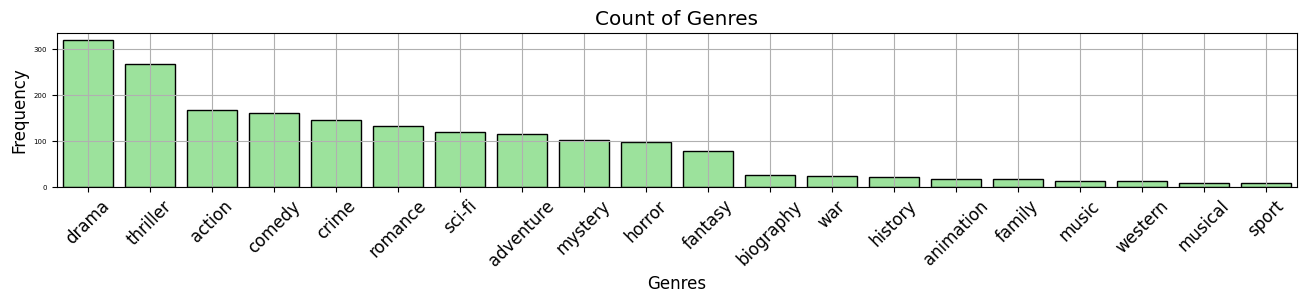

Genres   
drama        17.1%
thriller     14.4%
action        9.0%
comedy        8.7%
crime         7.9%
romance       7.1%
sci-fi        6.4%
adventure     6.2%
mystery       5.5%
horror        5.3%
Name: proportion, dtype: object
Genres   
drama        320
thriller     269
action       168
comedy       162
crime        147
romance      132
sci-fi       120
adventure    116
mystery      102
horror        99
Name: count, dtype: int64


In [ ]:
genres = []
for d in dataset.movies.values():
  genres += d['genres']
plot_categorical_attribute('Genres', genres)

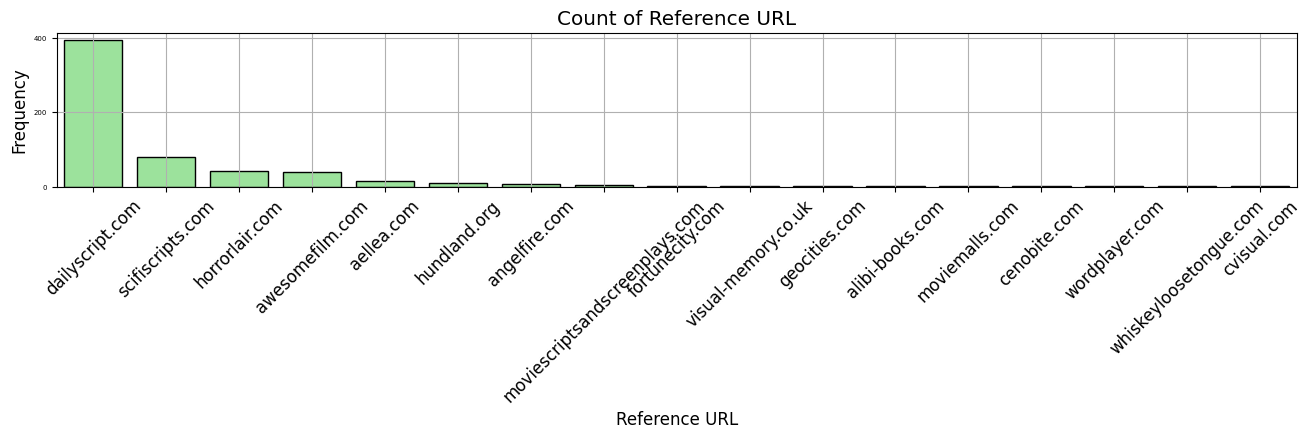

Reference URL                 
dailyscript.com                   64.9%
scifiscripts.com                  13.0%
horrorlair.com                     6.9%
awesomefilm.com                    6.8%
aellea.com                         2.8%
hundland.org                       1.8%
angelfire.com                      1.5%
moviescriptsandscreenplays.com     0.7%
fortunecity.com                    0.3%
whiskeyloosetongue.com             0.2%
Name: proportion, dtype: object
Reference URL                 
dailyscript.com                   394
scifiscripts.com                   79
horrorlair.com                     42
awesomefilm.com                    41
aellea.com                         17
hundland.org                       11
angelfire.com                       9
moviescriptsandscreenplays.com      4
fortunecity.com                     2
whiskeyloosetongue.com              1
Name: count, dtype: int64


In [ ]:
# Visualize movie url references statistics
plot_categorical_attribute('Reference URL', [re.findall('://www.([\w\-\.]+)', d['url'])[0] for d in dataset.movies.values() if len(re.findall('://www.([\w\-\.]+)', d['url']))>0])

**Movies Analysis**

| Attribute       | Mean    | Standard Deviation | Min  | 25%    | 50%     | 75%    | Max    |
|-----------------|---------|--------------------|------|--------|---------|--------|--------|
| Year            | 1988.58 | 16.59             | 1927 | 1984   | 1994    | 1999   | 2010   |
| IMDB Rating     | 6.86    | 1.22               | 2.5  | 6.2    | 7.0     | 7.8    | 9.3    |
| IMDB Votes      | 49820.96| 61880.61           | 9    | 9919   | 27112   | 66781  | 419312 |
| Characters      | 14.64   | 5.63               | 2    | 11     | 14      | 18     | 44     |
| Utterances      | 493.86  | 228.21             | 6    | 330    | 474     | 625    | 1530   |
| Conversations   | 134.68  | 51.63              | 1    | 98     | 133     | 166    | 338    |

Total amount of movies : 617

The average movie in the dataset was released around 1980-2000, has an IMDB rating of around 7, and received approximately 50k votes. The movies in the dataset typically feature around 10-20 characters, with approximately 300-600 utterances and 90-180 conversations. It is important to remark that the best movies are also the most popular ones (more votes implies better rating), and the more characters in the movie more dialog lines.

Additionally, drama is the most common genre, accounting for 17.1% of the movies, followed by thriller (14.4%), action (9.0%), and comedy (8.7%). The most common genre combination involves drama with the top being 'drama' (34 movies), followed by 'comedy, romance' (17 movies), 'crime, drama, thriller' (16 movies), 'comedy, drama, romance' (16 movies), 'comedy, drama' (15 movies), and 'drama, romance' (15 movies).

Moreover, the majority of scripts (64.9%) are sourced from dailyscript.com, followed by scifiscripts.com (13.0%) and horrorlair.com (6.9%).

#### Characters

In [ ]:
# Transform the characters dictionary to a Pandas DataFrame
characters_df = pd.DataFrame.from_dict(dataset.characters, orient='index')
characters_df['utterances'] = [len(dataset.get_utterances_by_character(id)) for id in dataset.characters.keys()]
#characters_df['conversations'] = [len(dataset.get_conversations_by_character(id)) for id in dataset.characters.keys()]

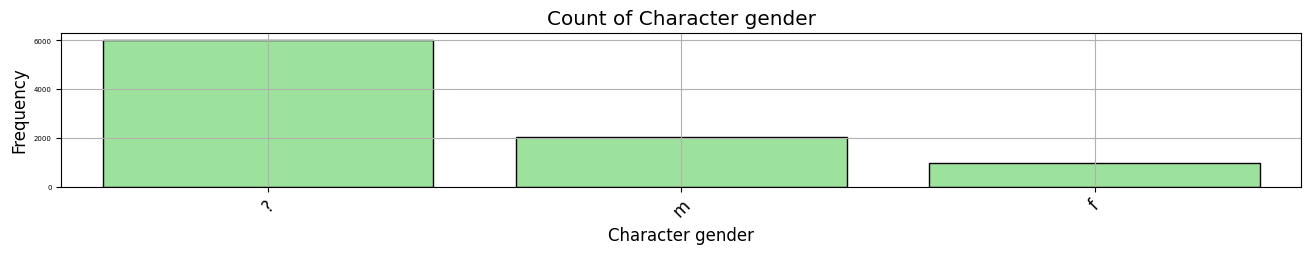

Character gender
?                   66.6%
m                   22.7%
f                   10.7%
Name: proportion, dtype: object
Character gender
?                   6020
m                   2049
f                    966
Name: count, dtype: int64


In [ ]:
# Visualize character gender statistics
plot_categorical_attribute('Character gender', [str(d['gender']) for d in dataset.characters.values()])

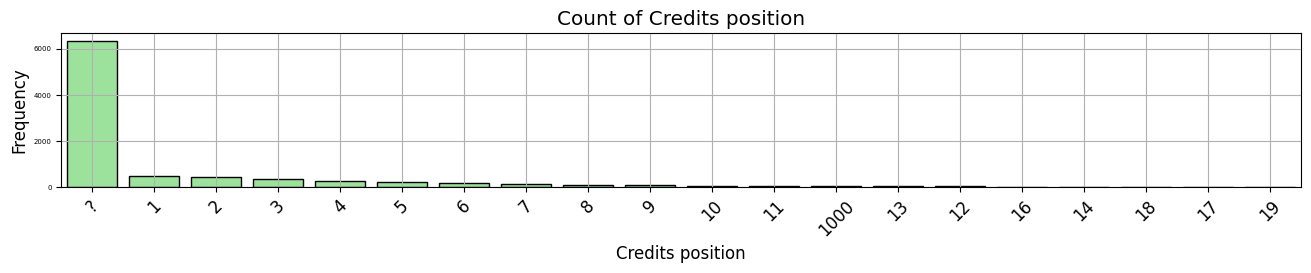

Credits position
?                   70.3%
1                    5.5%
2                    4.9%
3                    3.9%
4                    3.0%
5                    2.3%
6                    1.9%
7                    1.4%
8                    1.1%
9                    0.9%
Name: proportion, dtype: object
Credits position
?                   6356
1                    497
2                    443
3                    352
4                    268
5                    211
6                    169
7                    125
8                    100
9                     79
Name: count, dtype: int64


In [ ]:
# Visualize character position in credits statistics
plot_categorical_attribute('Credits position', [str(d['pos_credits']) for d in dataset.characters.values()])

<Figure size 600x200 with 0 Axes>

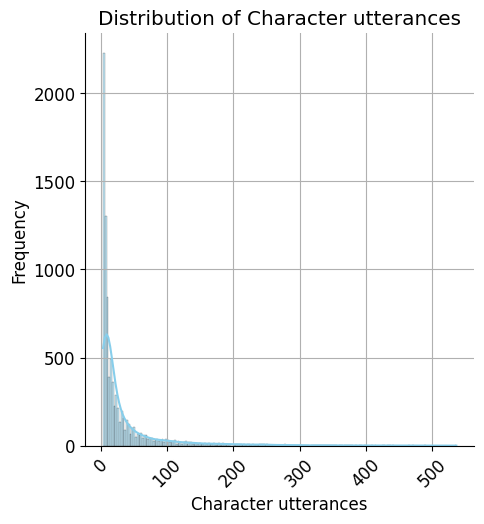

count    9035.000000
mean       33.725844
std        54.722218
min         3.000000
25%         6.000000
50%        12.000000
75%        34.000000
max       537.000000
Name: utterances, dtype: float64


<Figure size 600x200 with 0 Axes>

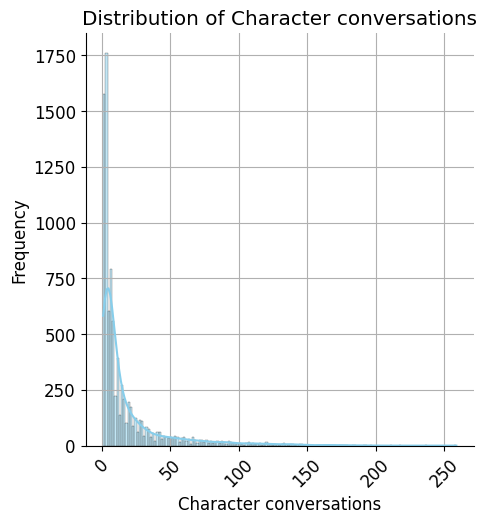

count    9035.000000
mean       18.394466
std        28.123483
min         1.000000
25%         3.000000
50%         7.000000
75%        20.000000
max       259.000000
Name: conversations, dtype: float64


<Axes: xlabel='conversations', ylabel='utterances'>

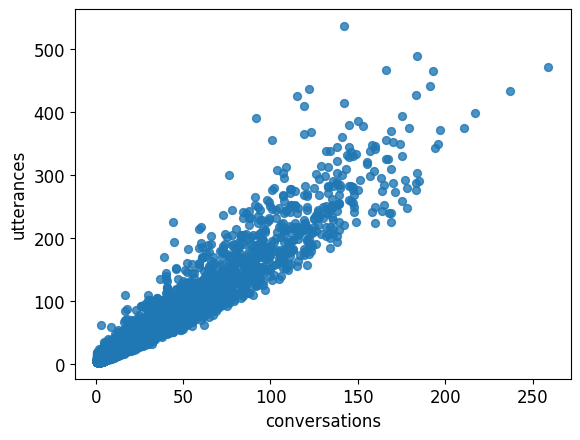

In [ ]:
# Visualize character utterance statistics
plot_numerical_attribute('Character utterances', characters_df['utterances'])
print(characters_df['utterances'].describe())
plot_numerical_attribute('Character conversations', characters_df['conversations'])
print(characters_df['conversations'].describe())
characters_df.plot(kind='scatter', x='conversations', y='utterances', s=32, alpha=.8)

In [ ]:
# Characters with the most dialogs
characters_df.sort_values(by=['conversations'], ascending=False).iloc[:15]

,name,movie_id,gender,pos_credits,utterances,conversations
u1475,JOE,m100,m,?,472,259
u2340,NIXON,m150,m,1,434,237
u3497,GRADY,m230,m,1,398,217
u4941,ED,m329,m,1,375,211
u4405,FERGUS,m292,m,3,372,197
u603,DIGNAN,m38,m,2,350,196
u5076,ERIN,m336,f,1,343,194
u4331,ACE,m289,m,1,465,193
u1094,ENID,m72,f,1,441,191
u5200,JACK,m344,m,1,291,185


In [ ]:
characters_df.sort_values(by=['utterances'], ascending=False).iloc[:15]

,name,movie_id,gender,pos_credits,utterances,conversations
u4525,DANTE,m299,m,1,537,142
u1169,BEN,m77,m,2,489,184
u1475,JOE,m100,m,?,472,259
u3681,ALVY,m243,m,1,467,166
u4331,ACE,m289,m,1,465,193
u1094,ENID,m72,f,1,441,191
u4460,MASON,m295,m,2,436,122
u2340,NIXON,m150,m,1,434,237
u4477,GITTES,m296,m,1,428,183
u4449,ARLO,m295,m,1,425,115


In [ ]:
# Characters with the least dialogs
characters_df.sort_values(by=['utterances'], ascending=True).iloc[:10]

,name,movie_id,gender,pos_credits,utterances,conversations
u2498,BIG BOB,m162,?,?,3,2
u4588,WOMAN,m302,?,?,3,1
u4583,MAN,m302,?,?,3,1
u4581,KID #1,m302,?,?,3,3
u1828,SLIM,m120,?,?,3,2
u7592,IZZY,m513,?,?,3,1
u400,MR. T,m24,?,?,3,1
u2713,BRAD AND JANET,m177,?,?,3,1
u7601,OPERATOR'S VOICE,m513,?,?,3,1
u1275,OFFICER,m84,?,?,3,1


In [ ]:
# Difference between main characters dialog count
print(characters_df[['utterances', 'conversations']].describe())
print('\nMain characters:')
print(characters_df[characters_df['pos_credits'].isin(['1','2','3','4'])][['utterances', 'conversations']].describe())
print('\nSecondary characters:')
print(characters_df[~characters_df['pos_credits'].isin(['1','2','3','4'])][['utterances', 'conversations']].describe())

        utterances  conversations
count  9035.000000    9035.000000
mean     33.725844      18.394466
std      54.722218      28.123483
min       3.000000       1.000000
25%       6.000000       3.000000
50%      12.000000       7.000000
75%      34.000000      20.000000
max     537.000000     259.000000

Main characters:
        utterances  conversations
count  1560.000000    1560.000000
mean    107.463462      57.110256
std      81.997637      39.495187
min      14.000000       3.000000
25%      45.750000      26.000000
50%      84.000000      47.000000
75%     144.250000      79.000000
max     537.000000     237.000000

Secondary characters:
        utterances  conversations
count  7475.000000    7475.000000
mean     18.337124      10.314649
std      29.074863      15.890017
min       3.000000       1.000000
25%       5.000000       3.000000
50%       9.000000       5.000000
75%      20.000000      11.000000
max     472.000000     259.000000


**Characters Analysis**

Total characters: 9035

In terms of character gender, the majority of characters have an unspecified gender (?), comprising 66.6% of the dataset, followed by male (22.7%) and female (10.7%) characters.

Regarding credits position, the majority of characters hold an unspecified position (70.3%), while positions 1 to 9 constitute the remainder of the dataset.

Analyzing the utterances and conversations metrics provides further granularity; the median utterances and conversations counts across all characters are approximately 12 and 7, respectively. Notably, main characters (top positions in credits), representing 17.3% of the dataset, exhibit higher utterances 50-150 (107 on average) and conversations 30-90 (57 on average) compared to secondary or unranked characters, who contribute to the majority of the dataset with an around 3-30 utterances and 1-20 conversations.

#### Conversations

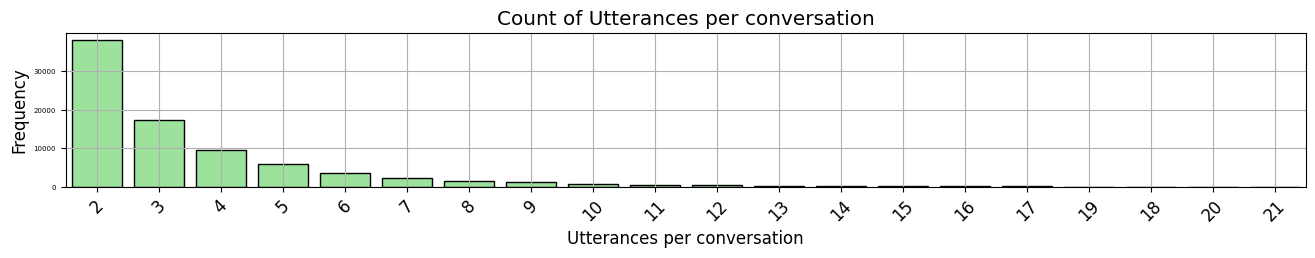

Utterances per conversation
2                              45.8%
3                              21.0%
4                              11.4%
5                               7.1%
6                               4.5%
7                               2.9%
8                               1.9%
9                               1.5%
10                              0.9%
11                              0.7%
Name: proportion, dtype: object
Utterances per conversation
2                              38091
3                              17459
4                               9492
5                               5895
6                               3723
7                               2377
8                               1563
9                               1206
10                               715
11                               591
Name: count, dtype: int64


In [ ]:
# Visualize conversation statistics
plot_categorical_attribute('Utterances per conversation', [len(conversation) for conversation in dataset.conversations])

In [ ]:
# List of all dialog lines
texts = dataset.get_utterance_texts_list()

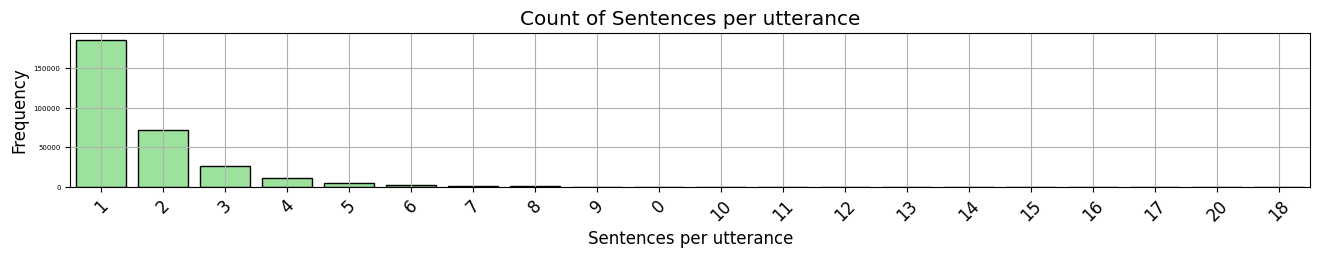

Sentences per utterance
1                          60.8%
2                          23.5%
3                           8.7%
4                           3.5%
5                           1.6%
6                           0.8%
7                           0.4%
8                           0.2%
9                           0.1%
0                           0.1%
Name: proportion, dtype: object
Sentences per utterance
1                          185281
2                           71731
3                           26570
4                           10740
5                            4752
6                            2303
7                            1248
8                             669
9                             418
0                             267
Name: count, dtype: int64


In [ ]:
# Visualize utterance statistics
plot_categorical_attribute('Sentences per utterance', [len(sent_tokenize(text)) for text in texts])

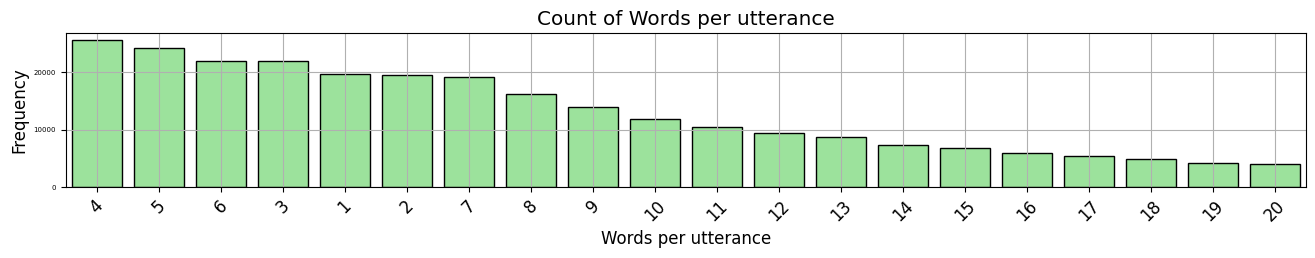

Words per utterance
4                      8.4%
5                      7.9%
6                      7.2%
3                      7.2%
1                      6.4%
2                      6.4%
7                      6.3%
8                      5.3%
9                      4.6%
10                     3.9%
Name: proportion, dtype: object
Words per utterance
4                      25537
5                      24129
6                      21943
3                      21892
1                      19635
2                      19436
7                      19234
8                      16269
9                      13946
10                     11887
Name: count, dtype: int64


In [ ]:
# Visualize utterance statistics
plot_categorical_attribute('Words per utterance', [len([word for word in word_tokenize(text) if word not in string.punctuation]) for text in texts])

**Conversation Analysis**

Total utterances: 304713

Total conversations: 83097

Overall, there are 2-4 utterances per conversation, the majority of conversations comprise 2 utterances, accounting for 45.8% of the dataset, followed by 3 utterances at 21.0%, and 4 utterances with 11.4%. This distribution indicates a prevalent trend towards shorter interactions.

Furthermore, single-sentence utterances dominate the dataset, representing 60.8%, while 2 sentence per utterance represents 23.5% and multi-sentence utterances exhibit a negligible percentage with decreasing trend.

Finally, the average word count per utterance indicates that utterances tend to be concise, with the majority (68.4%) consisting of 1 to 8 words.


This analysis encapsulates the conversational dynamics and linguistic characteristics inherent in the dataset.

In [ ]:
def get_ngram_vocab(texts, n_gram=1):
  '''
  Generate vocabulary based on n-grams from a list of texts.
  params:
  - texts (list): List of strings containing the utterances
  - n_gram (int): The size of n-grams to generate. Default is 1 (unigrams)
  returns:
  - vocab (Counter): Counter object containing the n-gram vocabulary and their frequencies
  '''
  corpus_words = []
  for line in texts:
    line = line.strip().lower()
    corpus_words += [word for word in word_tokenize(line) if word not in string.punctuation]

  return Counter(ngrams(corpus_words, n_gram))

In [ ]:
# Vocabulary
vocab = get_ngram_vocab(texts)
print(f'{len(vocab)} distinct words (vocabulary size)')
vocab.most_common(200)

58770 distinct words (vocabulary size)


[(('you',), 148382),
 (('i',), 141047),
 (('the',), 99124),
 (('to',), 80636),
 (('a',), 70852),
 (("'s",), 66535),
 (('it',), 66067),
 (("n't",), 55219),
 (('...',), 50796),
 (('do',), 47046),
 (('that',), 46567),
 (('and',), 45921),
 (('of',), 39336),
 (('what',), 37720),
 (('in',), 34127),
 (('me',), 32192),
 (('is',), 31635),
 (('we',), 29288),
 (('he',), 27406),
 (('--',), 26662),
 (('this',), 24611),
 (('for',), 23409),
 (('have',), 22934),
 (("'m",), 22577),
 (("'re",), 21716),
 (('know',), 21657),
 (('was',), 21407),
 (('your',), 20963),
 (('my',), 20822),
 (('not',), 19878),
 (('on',), 19557),
 (('no',), 19426),
 (('be',), 19413),
 (('are',), 17599),
 (('but',), 17312),
 (('with',), 17246),
 (('they',), 16941),
 (('just',), 15852),
 (('all',), 15390),
 (('like',), 15005),
 (("'ll",), 14613),
 (('did',), 14544),
 (('there',), 14444),
 (('get',), 14150),
 (('about',), 13998),
 (('so',), 13447),
 (('out',), 13334),
 (('got',), 13308),
 (('if',), 13209),
 (('here',), 13158),
 (('s

In [ ]:
# 2-grams
bigrams = get_ngram_vocab(texts, 2)
print(f'{len(bigrams)} distinct bigrams')
bigrams.most_common(200)

755752 distinct bigrams


[(('do', "n't"), 24308),
 (('i', "'m"), 22465),
 (('it', "'s"), 18056),
 (('you', "'re"), 13576),
 (('i', 'do'), 11859),
 (('that', "'s"), 10985),
 (('in', 'the'), 8322),
 (('do', 'you'), 8115),
 (('you', 'know'), 7118),
 (('i', "'ll"), 6872),
 (('he', "'s"), 6714),
 (('are', 'you'), 6654),
 (('ca', "n't"), 6622),
 (('...', 'i'), 6258),
 (('did', "n't"), 5869),
 (('you', 'do'), 5788),
 (('going', 'to'), 5729),
 (('of', 'the'), 5469),
 (("n't", 'know'), 5412),
 (('i', "'ve"), 5319),
 (('want', 'to'), 5271),
 (('to', 'be'), 5180),
 (('i', 'was'), 5094),
 (("'s", 'a'), 5047),
 (('and', 'i'), 4990),
 (('what', "'s"), 4849),
 (('i', 'know'), 4669),
 (('have', 'to'), 4618),
 (('we', "'re"), 4608),
 (('this', 'is'), 4562),
 (('if', 'you'), 4502),
 (('gon', 'na'), 4319),
 (('on', 'the'), 4283),
 (('i', 'have'), 4254),
 (('to', 'the'), 4148),
 (("n't", 'you'), 3970),
 (('there', "'s"), 3901),
 (('it', 'was'), 3873),
 (("'s", 'the'), 3825),
 (('i', 'think'), 3586),
 (('out', 'of'), 3526),
 (('bu

In [ ]:
# 3-grams
trigrams = get_ngram_vocab(texts, 3)
print(f'{len(trigrams)} distinct trigrams')
trigrams.most_common(200)

1968321 distinct trigrams


[(('i', 'do', "n't"), 10310),
 (('do', "n't", 'know'), 4642),
 (('you', 'do', "n't"), 3739),
 (('i', "'m", 'not'), 3019),
 (('i', 'ca', "n't"), 2864),
 (('what', 'do', 'you'), 2348),
 (('i', 'did', "n't"), 2109),
 (('do', "n't", 'you'), 2067),
 (('it', "'s", 'a'), 1933),
 (('what', 'are', 'you'), 1880),
 (('i', "'m", 'sorry'), 1796),
 (('do', "n't", 'want'), 1714),
 (('it', "'s", 'not'), 1708),
 (('i', "'m", 'going'), 1452),
 (('i', 'want', 'to'), 1432),
 (('you', 'ca', "n't"), 1380),
 (('you', "'re", 'not'), 1374),
 (('you', 'want', 'to'), 1355),
 (("n't", 'want', 'to'), 1308),
 (('do', 'you', 'think'), 1291),
 (('do', "n't", 'have'), 1276),
 (('i', "'ve", 'got'), 1275),
 (('do', "n't", 'think'), 1253),
 (('that', "'s", 'what'), 1224),
 (("'m", 'going', 'to'), 1114),
 (('you', "'re", 'a'), 1100),
 (('a', 'lot', 'of'), 1072),
 (('i', 'have', 'to'), 1067),
 (("'re", 'going', 'to'), 1063),
 (('do', 'you', 'know'), 1013),
 (('...', 'i', "'m"), 1006),
 (('i', "'ve", 'been'), 1003),
 (('do'

**Vocabulary Analysis**

- **Vocabulary size: 58,770**
- Distinct 2-grams: 755,752
- Distinct 3-grams: 1'968,321

The vocabulary and n-gram frequencies provides a glance of some patterns of language usage and common linguistic elements.

Vocabulary insights:
- Pronouns are the most frequent words in movie dialogues
- Followed by articles (really common in English) and action verbs
- Contractions are prominent (e.g. 's, n't, 've, 'd)
- Interesting frequent words
  - good/great
  - something/anything/nothing/everything/things
  - people
  - sorry/please
  - love
  - night/day
  - work
  - money
  - god/hell
  - sh\*\*/f\*\*k
  - old/new

2-gram and 3-gram insights:
- Contractions are prominent in movie dialogues (e.g. don't, I'm, it's, you're, that's)
- Common English constructions (verb + to), (pronoun + is), (pronoun + verb)...
- Interesting frequent 2/3-grams:
  - love you
  - thank you
  - I'm sorry
  - don't worry
  - of course
  - as soon as
  - don't know
  - I'm afraid
  - New York

**--> American drama movies**



### Basic Regular Expression conversation search
Retrieves all dialogues that matches the regular expression

In [ ]:
def dialogue_regex_search(regex_str):
  '''
  Searches for conversations containing a specified regex pattern.
  params:
  - regex_str (str): Regex pattern to search for in the conversation texts
  returns:
  - conversations (list): List of conversation IDs containing the specified regex pattern
  '''
  conversations = set()
  for conversation in dataset.conversations:
    for line_id in conversation:
      text = dataset.utterances[line_id]['text']
      if len(re.findall(regex_str, text)) > 0:
        conversations.add(str(conversation)) # found match in a line of the conversation
        break
  conversations = [ast.literal_eval(conv) for conv in conversations]
  return conversations

We can use the power of Regular Expressions to find patterns in the movie utterances and retrive the movie conversations that contain specific patterns.

Some examples of why this is useful:
- Search for emotions in the conversations
- Search for conversations that contain famous quotes
- Search for specific words or topics mentioned on conversations
- Search common phrases or dialogue dynamics
- Search for sentence structures and patterns

In [ ]:
# Example Regular Expression searches
regex_searches = ["happy|sad|angry|excited", "(M|m)ay the (F|f)orce be with you", "(B|b)etrayal", "everything's under control", "(I|i)f.+then.+\."]

for reg in regex_searches:
  print('-'*15)
  print(f'--> Regular Expression: "{reg}"')
  results = dialogue_regex_search(reg)
  print(f'{len(results)} conversations')
  for i in range(2):
    print(dataset.conversation_to_string(results[i]))

---------------
--> Regular Expression: "happy|sad|angry|excited"
1328 conversations
dead poets society (1989)
CHARLIE: I here and now commit myself to daring!
KEATING: So avoid using the word 'very' because it's lazy.  A man is not very tired, he is exhausted.  Don't use very sad, use morose.  Language was invented for one reason, boys--to woo women--and, in that endeavor, laziness will not do.  It also won't do in your essays.

shampoo (1975)
LESTER: You live like a pig.
GEORGE: Yeah.  How long have you been here?
LESTER: All night.
GEORGE: Well... who are those guys?
LESTER: What do they look like?...
GEORGE: Look, Lester... are you unhappy with me about something?
LESTER: Yeah, I'm unhappy with you about something.
GEORGE: Well, what?
LESTER: Godammit, George...
GEORGE: Now wait a minute...
LESTER: Sit down.
GEORGE: But...
LESTER: I said sit down!

---------------
--> Regular Expression: "(M|m)ay the (F|f)orce be with you"
2 conversations
star wars (1977)
BEN: That's straight throu

### Indexing

In [ ]:
def get_index_dataframe():
  '''
  Creates a DataFrame for indexing conversations in PyTerrier
  returns:
  - df (DataFrame): DataFrame containing indexed conversations with movie metadata
  '''
  df = []
  columns = ['docno', 'conversation', 'movie_title', 'movie_year', 'movie_rating', 'movie_votes', 'movie_genres']
  for conversation in dataset.conversations:
    movie = dataset.movies[dataset.utterances[conversation[0]]['movie_id']]
    row = [conversation[0], dataset.conversation_to_string(conversation),
           movie['title'], movie['year'], movie['IMDB_rating'], movie['IMDB_votes'], movie['genres']]
    df.append(row)
  return pd.DataFrame(df, columns=columns).applymap(str)

In [ ]:
# Get the DataFrame for indexing and searching
docs_df = get_index_dataframe()
docs_df.head()

,docno,conversation,movie_title,movie_year,movie_rating,movie_votes,movie_genres
0,L194,10 things i hate about you (1999)\nBIANCA: Can...,10 things i hate about you,1999,6.9,62847,"['comedy', 'romance']"
1,L198,10 things i hate about you (1999)\nBIANCA: You...,10 things i hate about you,1999,6.9,62847,"['comedy', 'romance']"
2,L200,"10 things i hate about you (1999)\nBIANCA: No,...",10 things i hate about you,1999,6.9,62847,"['comedy', 'romance']"
3,L204,10 things i hate about you (1999)\nCAMERON: Wh...,10 things i hate about you,1999,6.9,62847,"['comedy', 'romance']"
4,L207,10 things i hate about you (1999)\nBIANCA: Gos...,10 things i hate about you,1999,6.9,62847,"['comedy', 'romance']"


In [ ]:
# Create index with Pyterrier
PT_INDEX_PATH = os.path.join(os.getcwd(), 'index_movie_dialogs')

indexer = pt.DFIndexer(PT_INDEX_PATH, overwrite=True)
# DEFAULT meta_reverse=['docno'], stemmer=TerrierStemmer.porter, stopwords=TerrierStopwords.terrier, tokeniser=TerrierTokeniser.english, type=IndexingType.CLASSIC,
index_ref = indexer.index(docs_df['conversation'], docs_df)
index = pt.IndexFactory.of(index_ref)

In [ ]:
# Index statistics
print(index.getCollectionStatistics().toString())

Number of documents: 83097
Number of terms: 33771
Number of postings: 1596073
Number of fields: 0
Number of tokens: 1971186
Field names: []
Positions:   false



 - `Nt` is the number of unique documents that each term occurs in
 - `TF` is the total number of occurrences of term in corpus

In [ ]:
# Inspect frequency of interesting vocabulary terms
vocab_terms = ['love', 'work', 'feel', 'god', 'monei']
for term in vocab_terms:
  print(f'{term}: {index.getLexicon()[term].toString()}')

love: term449 Nt=3765 TF=4981 maxTF=14 @{0 1055458 7}
work: term132 Nt=3894 TF=4528 maxTF=5 @{0 1940334 2}
feel: term909 Nt=2676 TF=3177 maxTF=10 @{0 589562 5}
god: term156 Nt=2648 TF=3027 maxTF=5 @{0 698250 4}
monei: term580 Nt=2158 TF=2787 maxTF=6 @{0 1154405 6}


In [ ]:
def simple_query(batch_retriever, query, df):
  '''
  Perform a simple query and print the retrieved/ranked conversations
  params:
  - batch_retriever (BatchRetrieve): PyTerrier BatchRetrieve object configured with a retrieval model
  - query (str): Query text to search for.
  - df (DataFrame): DataFrame containing indexed conversations with document metadata
  '''
  results = batch_retriever.search(query)
  for docno in results['docno']:
    print(df[df['docno'] == docno]['conversation'].values[0])

In [ ]:
# (tf_idf % 50) >> (bm25 % 10() (retrieve top-50 using TF_IDF and rerank with BM25 to retrieve top-10)
br_pipeline = (pt.BatchRetrieve(index, wmodel="TF_IDF") % 50) >> (pt.BatchRetrieve(index, wmodel="BM25") % 10)
simple_query(br_pipeline, 'what is love', docs_df)

crazy love (2007)
LETTY: I love you so much.
MICHAEL: I love you too, Letty.     I love you, too.

runaway bride (1999)
IKE: I love you.  I love you.
MAGGIE: I love you, too.

frances (1982)
FRANCES: I love you, Harry. I love you.
HARRY: I love you too, Frances.

bachelor party (1984)
O'NEILL: So, Larry, how have you been?
LARRY: Just in love with everybody. It's really a beautiful planet. I love you, Rick. I love you guys. I love everybody.

minority report (2002)
ANDERTON: Four.  Wow.  What a big boy.  I love you, Sean.
SEAN: I love you, too!  I love you daddy.  Love ya, dad.

shock treatment (1981)
NATION: Isn't she lovely?
MOM: Mommy and Daddy love you, Baby.
NATION: She walks in beauty...
MOM: We love you, Baby.
NATION: We all love Janet...Who do we love?

citizen kane (1941)
KANE: You're talking an incredible amount of nonsense, Susan.  Whatever I do -  I do - because I love you.
SUSAN: Love!  You don't love anybody!  Me or anybody else!  You want to be loved - that's all you wan

The index retrieved dialogues where love is the main topic or it is expressed by some character.

In [ ]:
simple_query(br_pipeline, 'star wars leaders', docs_df)

star wars (1977)
LUKE: I'm right behind you, Blue Leader.
BLUE LEADER: What's that?

star wars (1977)
BLUE LEADER: Blue Five, does that glare bother you?
LUKE: I've got it blocked.  I'm all right.

star wars: episode vi - return of the jedi (1983)
LANDO: All wings report in.
WEDGE: Red Leader standing by.

star wars (1977)
BLUE LEADER: You're Starkiller?
LUKE: Yes, sir.
BLUE LEADER: Have you been checked out?
LUKE: Yes, sir.  I was considered one of the best bush pilots on Sullust. I've also had six hours on the T-2.

star wars (1977)
BLUE LEADER: Blue Five, break off your cover attack.  It's too late.  Make your own run on the exhaust port.  Do you copy, Luke?
LUKE: Yes, sir, but I can get him...
BLUE LEADER: Forget it, son.

star wars: episode vi - return of the jedi (1983)
WEDGE: There it is!
LANDO: All right, Wedge. Go for the power regulator on the north tower.
WEDGE: Copy, Gold Leader. I'm already on my way out.

star wars (1977)
BLUE LEADER: Six hours, huh?  Well, that's your sh

The index was able to retrieve the Star Wars movie dialogues were some leaders participate or are mentioned (e.g. red leader, gold leader, blue leader)

**Searching considering movie metadata**

In [ ]:
# Perform BM25 > create feature vector > retrieve top-200 according to query
# > rescore according to features > retrieve top-10 according to rescore
br_pipeline_metascoring = (pt.BatchRetrieve(index, wmodel="BM25", metadata=['docno', 'movie_year', 'movie_rating', 'movie_genres']) >> (
    pt.transformer.IdentityTransformer()
    ** # drama movies
    (pt.apply.doc_score(lambda row: int('drama' in row['movie_genres'])))
    ** # date between 1900 and 2000
    (pt.apply.doc_score(lambda row: int(1980 <= int(row['movie_year']) and 1990 > int(row['movie_year']))))
    ** # movie rating >= 7
    (pt.apply.doc_score(lambda row: int(7 <= float(row['movie_rating']))))
) % 200) >> (pt.apply.doc_score(lambda row: sum(row['features'])) % 10)

br_pipeline_metascoring.search('what is love')

,qid,docid,docno,movie_year,movie_rating,movie_genres,score,query,features,rank
2,1,8639,L221937,1982,7.2,"['biography', 'drama']",10.969378,what is love,"[7.969378454695602, 1.0, 1.0, 1.0]",0
12,1,45885,L169728,1989,7.9,['drama'],10.765237,what is love,"[7.765236559288622, 1.0, 1.0, 1.0]",1
29,1,68250,L483827,1989,7.5,"['comedy', 'drama', 'romance']",10.540899,what is love,"[7.540899384591832, 1.0, 1.0, 1.0]",2
46,1,82171,L657684,1988,7.1,"['action', 'adventure', 'drama', 'fantasy', 'r...",10.431008,what is love,"[7.431008381980566, 1.0, 1.0, 1.0]",3
47,1,12717,L285494,1987,7.4,"['drama', 'war']",10.427659,what is love,"[7.427659005379517, 1.0, 1.0, 1.0]",4
52,1,12701,L285311,1987,7.4,"['drama', 'war']",10.356225,what is love,"[7.356224684128395, 1.0, 1.0, 1.0]",5
60,1,8580,L221144,1982,7.2,"['biography', 'drama']",10.220563,what is love,"[7.220562695450945, 1.0, 1.0, 1.0]",6
83,1,2002,L30205,1984,8.4,"['biography', 'drama', 'music']",10.021708,what is love,"[7.021708359620253, 1.0, 1.0, 1.0]",7
99,1,61157,L391650,1987,7.1,"['comedy', 'romance', 'drama']",9.926333,what is love,"[6.92633273900382, 1.0, 1.0, 1.0]",8
4,1,17941,L386199,2002,7.7,"['action', 'crime', 'mystery', 'sci-fi', 'thri...",9.885315,what is love,"[7.885314982120678, 1.0, 0.0, 1.0]",9


In [ ]:
simple_query(br_pipeline_metascoring, 'what is love', docs_df)

frances (1982)
FRANCES: I love you, Harry. I love you.
HARRY: I love you too, Frances.

do the right thing (1989)
RADIO RAHEEM: Brother, Mookie, if I love you I love you, but if I hate you...
MOOKIE: I understand.
RADIO RAHEEM: I love you, my brother.
MOOKIE: I love you, Black.

say anything... (1989)
MARK: I love you man
LLOYD: I love you too.

willow (1988)
MADMARTIGAN: She's in love.
WILLOW: You're crazy.  I think you're in love.

hope and glory (1987)
MAC: She said, 'I know you love me, Mac, but you've never loved me enough.'
GRACE: Not loving enough. That is a terrible thing to do to someone. I suppose I did it to Clive. Always held something back.

hope and glory (1987)
GRACE: You better bring him home, if you really love him. Don't kill love. You'll regret it for the rest of your life.
DAWN: Who said anything about love?

frances (1982)
FRANCES: I love you, Mama.  I love you, Dad.
ERNEST: Be careful, Francie.

amadeus (1984)
MOZART: Love, Sire!
SALIERI: Ah, love! Well of course 

The retrieval pipeline with additional scoring on some metadata was able to search for the best matches to the query and then filter them with certain properties as movie year, rating and genre. Clearly, the results changed from the base BM25 alone without considering metadata.

In [ ]:
simple_query(br_pipeline_metascoring, 'go away', docs_df)

pleasantville (1998)
GEORGE: It goes away ... It'll go away.
BETTY: I don't want it to go away.

blade runner (1982)
DECKARD: She was gonna get away.
BRYANT: Then let her get away.  I thought you were a pro -- you're supposed to be a fuckin' tracker!

hope and glory (1987)
BRUCE: Take it away. I know your husband's been away a long time, but....
DAWN: Don't be so cheeky, Bruce.

tombstone (1993)
WYATT: No, no, get away, get away from me...
JOSEPHINE: Wyatt...

lost highway (1997)
PETE: You liked it.
ALICE: If you want me to go away, I'll go away.

an american werewolf in london (1981)
JACK: Nice doggie. Good boy.
DAVID: Walk away, Jack.
JACK: Walking away, yes, sir. Here we are walking away.

chinatown (1974)
GITTES: Get him away from her. He's responsible for everything. Get him away from her!
ESCOBAR: Jake, you're very disturbed. You're crazy. That's her father.

the shining (1980)
WENDY: Stay away from me!
JACK: I'm not going to hurt you.
WENDY: Stay away from me!

the elephant man 

From this point it is possbile to try different scorers, metadata and filters, but the results were quite good. The next step would be to create a better engine that learns how to rank (lambdaMART), but there are no qrels/labels to improve the ranking performance.

### Dialogue Clustering

- Load documents (conversations) to cluster
- Retrieve known labels of the documents (movie genres)

In [ ]:
cluster_df = get_index_dataframe()[['conversation', 'movie_genres']]
cluster_df['main_movie_genre'] = cluster_df['movie_genres'].apply(lambda x: ast.literal_eval(x)[0] if len(ast.literal_eval(x)) > 0 else 'drama')
cluster_df.head()

,conversation,movie_genres,main_movie_genre
0,10 things i hate about you (1999)\nBIANCA: Can...,"['comedy', 'romance']",comedy
1,10 things i hate about you (1999)\nBIANCA: You...,"['comedy', 'romance']",comedy
2,"10 things i hate about you (1999)\nBIANCA: No,...","['comedy', 'romance']",comedy
3,10 things i hate about you (1999)\nCAMERON: Wh...,"['comedy', 'romance']",comedy
4,10 things i hate about you (1999)\nBIANCA: Gos...,"['comedy', 'romance']",comedy


- 24 distinct movie genres
- 290 distinct genre combinations
- 2-4 genres per movie
- Drama and Thriller most frequent movie genres
- Between Drama, Comedy, Romance, and Thriller are the most frequent combinations

** For more statistics on movie genres, please refer to the Dataset Statistics section

In [ ]:
genres = []
for d in dataset.movies.values():
  genres += d['genres']
distinct_genres = sorted(list(set(genres)))

print(f'{len(distinct_genres)} distinct genres in the dataset:\n{distinct_genres}')

24 distinct genres in the dataset:
['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'film-noir', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sci-fi', 'short', 'sport', 'thriller', 'war', 'western']


In [ ]:
print(f'{len(cluster_df)} conversations')
distinct_genre_combination = sorted(cluster_df['movie_genres'].unique())
print(f'{len(distinct_genre_combination)} distinct genre combinations')

83097 conversations
290 distinct genre combinations


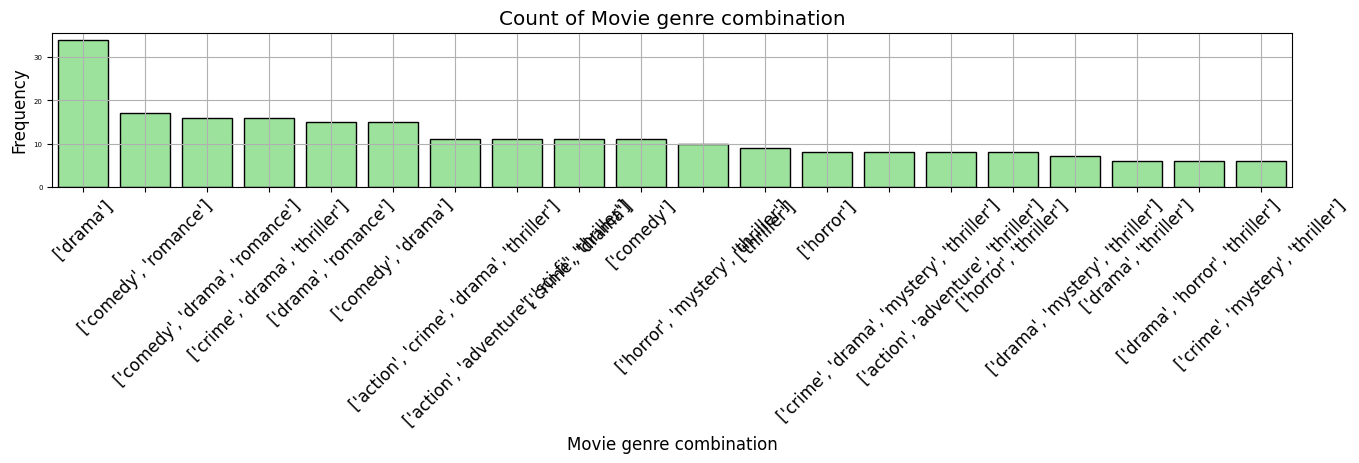

Movie genre combination                      
['drama']                                        5.5%
['comedy', 'romance']                            2.8%
['crime', 'drama', 'thriller']                   2.6%
['comedy', 'drama', 'romance']                   2.6%
['comedy', 'drama']                              2.4%
['drama', 'romance']                             2.4%
['action', 'crime', 'drama', 'thriller']         1.8%
['comedy']                                       1.8%
['action', 'adventure', 'sci-fi', 'thriller']    1.8%
['crime', 'drama']                               1.8%
Name: proportion, dtype: object
Movie genre combination                      
['drama']                                        34
['comedy', 'romance']                            17
['crime', 'drama', 'thriller']                   16
['comedy', 'drama', 'romance']                   16
['comedy', 'drama']                              15
['drama', 'romance']                             15
['action', 'crime', 'dra

In [ ]:
plot_categorical_attribute('Movie genre combination', [str(d['genres']) for d in dataset.movies.values()])

#### TF-IDF document vectorization
- Without most and least document frequent terms
- Without English stopwords
- 17,438 vocabulary size (huge space!)
- 18.17 average document (conversation) vocabulary size


In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
vector_documents = vectorizer.fit_transform(cluster_df['conversation'].values)
print(vector_documents.shape)

(83097, 17438)


In [ ]:
vocab = vectorizer.get_feature_names_out()
print(f'Length of vocabulary: {len(vocab)}')
print()
print(f"Average document vocabulary size: {vector_documents.count_nonzero()/vector_documents.get_shape()[0]}")
print()
print('Sample vocabulary terms:')
print(sorted(random.sample(vocab.tolist(),100)))

Length of vocabulary: 17438

Average document vocabulary size: 18.166973536950792

Sample vocabulary terms:
['aa', 'areas', 'asked', 'atlanta', 'attached', 'beauty', 'beloved', 'beryllium', 'bookstore', 'brute', 'bureau', 'calculate', 'canisters', 'chaffey', 'channing', 'circuit', 'closes', 'cody', 'collateral', 'commodore', 'confidence', 'connor', 'conscious', 'counts', 'deetzes', 'dispatches', 'disturbing', 'ditto', 'dopey', 'egelhoffer', 'elmer', 'entertainer', 'entrance', 'ethan', 'evasive', 'familiarity', 'galbraith', 'glad', 'gwen', 'hallie', 'hangar', 'hatred', 'hell', 'helpless', 'henley', 'hewitt', 'ho', 'hotel', 'hug', 'identical', 'identity', 'invasion', 'inventing', 'irritating', 'know', 'kurring', 'la', 'lanterns', 'lashindra', 'leads', 'life', 'lit', 'literary', 'livelihood', 'man', 'marotta', 'mugger', 'municipal', 'nineteen', 'oughtn', 'painless', 'passion', 'pissing', 'poet', 'port', 'pos', 'prefer', 'prominent', 'races', 'raheem', 'rains', 'raising', 'recess', 'return

In [ ]:
print('Inspection of first document:')
print(cluster_df['conversation'].values[0])
print()
print('Vector TF-IDF representation:')
print(vector_documents[0])
print()
print('Sorted TF-IDF score:')
sorted([(vocab[j], vector_documents[0, j]) for j in vector_documents[0].nonzero()[1]], key=lambda x: -x[1])

Inspection of first document:
10 things i hate about you (1999)
BIANCA: Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
CAMERON: Well, I thought we'd start with pronunciation, if that's okay with you.
BIANCA: Not the hacking and gagging and spitting part.  Please.
CAMERON: Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?


Vector TF-IDF representation:
  (0, 4)	0.15592372846197625
  (0, 97)	0.08312078559066739
  (0, 692)	0.1731361951745374
  (0, 1317)	0.22678163347169553
  (0, 1569)	0.3591948998205327
  (0, 1888)	0.15803873493270532
  (0, 1958)	0.13490539599829124
  (0, 2312)	0.37767940711662135
  (0, 3809)	0.2416008604294345
  (0, 6162)	0.15663457567895123
  (0, 6287)	0.24838286360332185
  (0, 6880)	0.23409342627903507
  (0, 7049)	0.13092302607237014
  (0, 7069)	0.13288871803102795
  (0, 7766)	0.20195399648178558
  (0, 9454)	0.09348762878573509
  (0, 10604)	0.1024001066676460

[('cameron', 0.37767940711662135),
 ('bianca', 0.3591948998205327),
 ('gagging', 0.24838286360332185),
 ('cuisine', 0.2416008604294345),
 ('roxanne', 0.23634033007956662),
 ('hacking', 0.23409342627903507),
 ('spitting', 0.23015518528007134),
 ('barrett', 0.22678163347169553),
 ('incredibly', 0.20195399648178558),
 ('okay', 0.19151423208252283),
 ('saturday', 0.17587255558492804),
 ('andrew', 0.1731361951745374),
 ('public', 0.16064582586150694),
 ('quick', 0.15899400783891265),
 ('bout', 0.15803873493270532),
 ('french', 0.15663457567895123),
 ('10', 0.15592372846197625),
 ('break', 0.13490539599829124),
 ('having', 0.13288871803102795),
 ('hate', 0.13092302607237014),
 ('start', 0.12578675792619365),
 ('try', 0.11853281704123564),
 ('thought', 0.10292003724475883),
 ('night', 0.10240010666764604),
 ('things', 0.10166445156372994),
 ('make', 0.09348762878573509),
 ('1999', 0.08312078559066739)]

**Cosine similarity [0,1] between documents**

In [ ]:
index1 = random.randint(0, len(cluster_df)-1)
index2 = random.randint(0, len(cluster_df)-1)
print('Movie genre of first document:', cluster_df['movie_genres'].values[index1])
print('Movie genre of first document:', cluster_df['movie_genres'].values[index2])
print(f'Cosine similarity: {vector_documents[index1].multiply(vector_documents[index2]).sum()}')

Movie genre of first document: ['horror', 'thriller']
Movie genre of first document: ['action', 'adventure', 'comedy', 'music']
Cosine similarity: 0.0


Conversations are short, so it is hard to get a proper overlapping. However, there is some overlap on documents that share some movie genres.

**Cosine similarity keyword searching**

In [ ]:
query = 'italy'
query_vec = vectorizer.transform([query])[0]

index = np.argmax([query_vec.multiply(vector_documents[i]).sum() for i in range(len(cluster_df))])
print(cluster_df['conversation'].values[index])

only you (1994)
FAITH: So, you say you've been to Italy before?
HIM: A few times.  It's kind of an annual tradi--



Clearly, result not as fast and precise as the previous index search with BM25!

#### K-means clustering

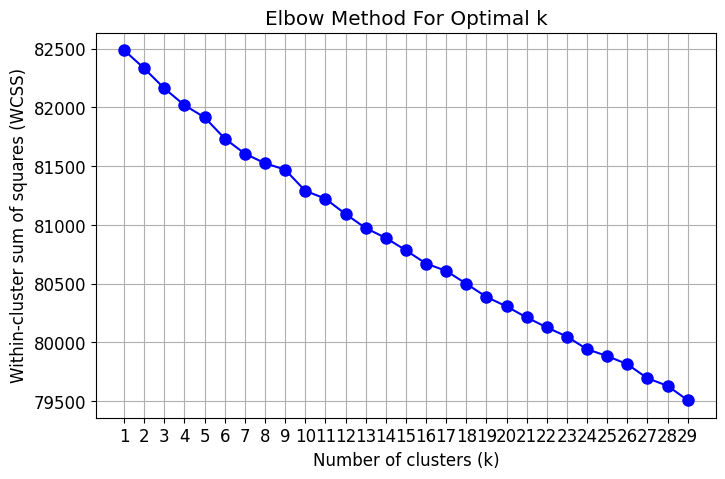

In [ ]:
k_values = range(1, 30)
wcss = []

# Compute WCSS for each k
for k in k_values:
  kmeans = KMeans(n_clusters=k, max_iter=100)
  kmeans.fit(vector_documents)
  wcss.append(kmeans.inertia_)

# Plot the WCSS against k values
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.xticks(k_values)
plt.show()

According to the Elbow method, the biggest jump (decrease) of the WCSS is at around k=x, which do not correspond to the 24 distinct genres categories. This might be caused due to the genre combinations, length of documents, vectorization method, and not using cosine similarity as clustering distance.

Hence, K-means will be compared using k=24 and k=290

In [ ]:
# K = 24 distinct movie genres
kmeans = KMeans(n_clusters=len(distinct_genres), max_iter=100, n_init=2)
kmeans.fit(vector_documents)
k24_labels = kmeans.labels_

print('Top terms per cluster:')
for i in range(kmeans.n_clusters):
  centroid = kmeans.cluster_centers_[i]
  sorted_terms = centroid.argsort()[::-1]
  print(f"Cluster {i} ({np.sum(k24_labels == i)} docs):\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0 (1886 docs):	['1987', 'mike', 'jaws', 'brody', 'frida', '1978', 'broadcast', 'news', 'jane', 'ellen']
Cluster 1 (38055 docs):	['don', 'know', 'll', 'just', 'like', '2001', 'got', 'man', 'want', 'right']
Cluster 2 (1757 docs):	['1986', 'lee', 'carter', 'hannah', 'peggy', 'sisters', 'jeffrey', 'maverick', 'holly', 'rush']
Cluster 3 (1752 docs):	['1982', 'frances', 'wars', 'han', 'star', 'cates', 'gandhi', 'luke', 'leia', 'hrs']
Cluster 4 (990 docs):	['joe', 'innerspace', 'al', 'parrish', '1987', 'black', 'meet', '1998', 'susan', 'rene']
Cluster 5 (1411 docs):	['1984', 'rick', 'indiana', 'jones', 'supergirl', 'mozart', 'jenny', 'casablanca', 'starman', 'indy']
Cluster 6 (2790 docs):	['1994', 'ed', 'nightmare', 'elm', 'street', 'faith', 'vampire', 'dante', 'dream', 'don']
Cluster 7 (919 docs):	['michael', 'halloween', 'myers', 'letty', '1987', 'rowan', 'godfather', 'julianne', 'wedding', 'witching']
Cluster 8 (1366 docs):	['nick', 'annie', 'alvy', 'whispere

In [ ]:
# K = 24 evaluation
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, k24_labels)))
print()
print('Extrinsic evaluation measures (on main movie genre):')
print("Homogeneity:", str(metrics.homogeneity_score(cluster_df['main_movie_genre'].values, k24_labels)))
print("Completeness:", str(metrics.completeness_score(cluster_df['main_movie_genre'].values, k24_labels)))
print("V-measure:", str(metrics.v_measure_score(cluster_df['main_movie_genre'].values, k24_labels)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(cluster_df['main_movie_genre'].values, k24_labels)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 80023.38132880349
Silhouette coefficient: 0.01099605035291918

Extrinsic evaluation measures (on main movie genre):
Homogeneity: 0.11595292559032179
Completeness: 0.1034423591890249
V-measure: 0.10934094768714436
Adjusted Rand-Index: 0.017177480368030542


In [ ]:
# K = 290 distinct movie genre combination
kmeans = KMeans(n_clusters=len(distinct_genre_combination), max_iter=100, n_init=2)
kmeans.fit(vector_documents)
k290_labels = kmeans.labels_

print('Top terms per cluster:')
for i in range(kmeans.n_clusters):
  centroid = kmeans.cluster_centers_[i]
  sorted_terms = centroid.argsort()[::-1]
  print(f"Cluster {i} ({np.sum(k290_labels == i)} docs):\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0 (336 docs):	['ethan', 'mission', 'impossible', 'nyah', 'searchers', '1956', 'supergirl', 'ii', 'martin', 'luther']
Cluster 1 (194 docs):	['agnes', 'martha', 'panic', 'miriam', 'room', 'meg', 'burnham', '2002', 'mother', 'raoul']
Cluster 2 (286 docs):	['dulaney', 'body', 'evidence', '1993', 'macfarlane', 'fettes', 'cardenas', 'snatcher', 'rebecca', '1945']
Cluster 3 (280 docs):	['joe', 'innerspace', 'al', '1987', 'rene', 'dieter', 'don', 'just', 'gruner', 'know']
Cluster 4 (191 docs):	['broadcast', 'jane', 'news', 'tom', 'aaron', '1987', 'ernie', 'okay', 'just', 'buddy']
Cluster 5 (158 docs):	['emmett', 'silverado', '1985', 'paden', 'professor', 'brown', 'cobb', 'mal', 'marty', 'stella']
Cluster 6 (274 docs):	['craig', 'malkovich', 'day', 'friday', 'maxine', '2000', 'lotte', 'john', 'roach', '1999']
Cluster 7 (194 docs):	['malcolm', '1992', 'archie', 'bembry', 'betty', 'jurassic', 'ain', 'park', 'man', 'shorty']
Cluster 8 (5081 docs):	['don', 'know', 'li

In [ ]:
# K = 290 evaluation
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, k290_labels)))
print()
print('Extrinsic evaluation measures (on genre combination):')
print("Homogeneity:", str(metrics.homogeneity_score(cluster_df['movie_genres'].values, k290_labels)))
print("Completeness:", str(metrics.completeness_score(cluster_df['movie_genres'].values, k290_labels)))
print("V-measure:", str(metrics.v_measure_score(cluster_df['movie_genres'].values, k290_labels)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(cluster_df['movie_genres'].values, k290_labels)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 66963.10435755871
Silhouette coefficient: 0.0699985655264664

Extrinsic evaluation measures:
Homogeneity: 0.6788973421711126
Completeness: 0.6820857789635696
V-measure: 0.6804878257197072
Adjusted Rand-Index: 0.0686338090611504


Transform the high dimensional data into low dimensional data (just 3 dimensions). For this, the linear dimensionality reduction technique called Singular Value Decomposition is used to transform the `vector_documents` to be 3 dimensional.

Text(0.5, 0.92, 'K=290 clustering')

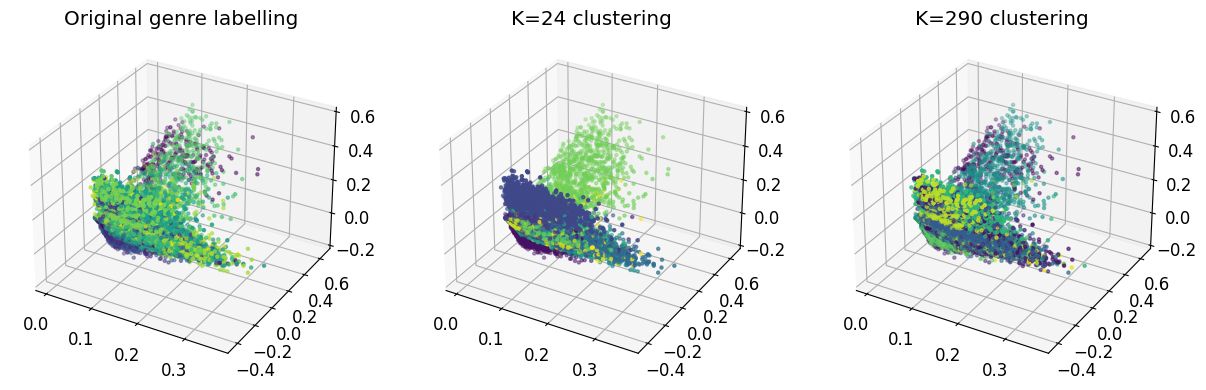

In [ ]:
svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(vector_documents)

[x,y,z] = np.transpose(reduced_data)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(x, y, z, c=LabelEncoder().fit_transform(cluster_df['movie_genres'].values), marker='.')
ax.set_title('Original genre labelling')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(x, y, z, c=k24_labels, marker='.')
ax.set_title('K=24 clustering')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(x, y, z, c=k290_labels, marker='.')
ax.set_title('K=290 clustering')

In [ ]:
cluster_df['k24_clustering'] = k24_labels
cluster_df['k290_clustering'] = k290_labels
cluster_df.head()

,conversation,movie_genres,k24_clustering,k290_clustering
0,10 things i hate about you (1999)\nBIANCA: Can...,"['comedy', 'romance']",21,20
1,10 things i hate about you (1999)\nBIANCA: You...,"['comedy', 'romance']",21,20
2,"10 things i hate about you (1999)\nBIANCA: No,...","['comedy', 'romance']",21,20
3,10 things i hate about you (1999)\nCAMERON: Wh...,"['comedy', 'romance']",21,20
4,10 things i hate about you (1999)\nBIANCA: Gos...,"['comedy', 'romance']",21,20


In [ ]:
cluster_df[cluster_df['k290_clustering'] == 34].tail(20)

,conversation,movie_genres,k24_clustering,k290_clustering
79582,u-turn (1973)\nJAKE: You'd tell me anything to...,['drama'],8,34
79640,u turn (1997)\nJAKE: Who the hell is this!?\nB...,"['crime', 'drama', 'thriller']",12,34
79642,u turn (1997)\nJAKE: You can't just walk in he...,"['crime', 'drama', 'thriller']",12,34
79648,"u turn (1997)\nJAKE: ""You can't shoot 'em!"" I ...","['crime', 'drama', 'thriller']",8,34
79649,u turn (1997)\nJAKE: Would you?\nBOBBY: Would ...,"['crime', 'drama', 'thriller']",12,34
79653,"u turn (1997)\nJAKE: Well, I guess I have what...","['crime', 'drama', 'thriller']",8,34
79655,"u turn (1997)\nJAKE: You drive a hard bargain,...","['crime', 'drama', 'thriller']",8,34
79656,u turn (1997)\nJAKE: If you can't trust the ma...,"['crime', 'drama', 'thriller']",8,34
79661,u turn (1997)\nJAKE: I guess this is what they...,"['crime', 'drama', 'thriller']",8,34
79663,u turn (1997)\nJAKE: Shhh! Liar.\nBOBBY: It's ...,"['crime', 'drama', 'thriller']",8,34


In [ ]:
cluster_df[cluster_df['k290_clustering'] == 115].head(50)

,conversation,movie_genres,k24_clustering,k290_clustering
81576,white angel (1994)\nDEZERAE: Which do you thin...,"['drama', 'thriller']",8,115
81577,white angel (1994)\nCARTER: I've got a tenant ...,"['drama', 'thriller']",4,115
81579,white angel (1994)\nDEZERAE: OH MY GAWD!\nCART...,"['drama', 'thriller']",4,115
81580,white angel (1994)\nCARTER: I thought you were...,"['drama', 'thriller']",4,115
81581,white angel (1994)\nCARTER: I thought someone ...,"['drama', 'thriller']",8,115
81582,white angel (1994)\nCARTER: Sounds good - than...,"['drama', 'thriller']",8,115
81583,"white angel (1994)\nCARTER: You see, I am writ...","['drama', 'thriller']",4,115
81584,white angel (1994)\nCARTER: When could I look ...,"['drama', 'thriller']",4,115
81585,white angel (1994)\nCARTER: That's very kind o...,"['drama', 'thriller']",2,115
81588,white angel (1994)\nMANAGER: Hello MRS STECKLE...,"['drama', 'thriller']",4,115


It seems that some clusters are being mapped to specific movies and characters (label 34 correspind to "10 things i hate about you" and label 79 to "saving private ryan").
- cluster 34 centroid : ['10', 'hate', 'kat', 'things', 'patrick', 'bianca', '1999', 'cameron', 'joey', 'michael']
- cluster 79 centroid : ['ryan', 'miller', 'saving', 'private', 'reiben', '1998', 'sarge', 'upham', 'jackson', 'sir']

Meanwhile some clusters capture genre informarion, for instance cluster 115 detected some drama movie dialogues combined with other genres (e.g. "the cider house rules", "titanic", "black snake moan", "air force one", "15 minutes")
- cluster 115 centroid : ['rose', 'rambling', 'daddy', '1991', 'titanic', 'buddy', 'mother', 'homer', 'cider', 'don']

Both K-Means clustering models did not performed really good and were not able to classify documents by genre. Intrinsic measures indicate clusters do not segregate documents significantly, and extrinsic measures denote lack of matching to movie genres. This bad performance can be due to the following:
- very short documents
- conversations can belong to multiple movie genres
- used euclidean distance instead of cosine similarity
- weighted too much by movie metadata (title, year, characters)

However, due to the content of the conversations, lexically, clustering was able to group conversations by movie and characters instead of genres. This is why K=290 performed better, since there were more available clusters to assign to each movie.

#### Other Clustering Algorithms

In [ ]:
# DBSCAN with cosine similarity metric
dbscan = DBSCAN(metric='cosine', min_samples=100)
dbscan.fit(vector_documents)
dbscan_labels = dbscan.labels_

print(f'{len(np.unique(dbscan_labels))} clusters')
print()
print('Extrinsic evaluation measures (on main genre):')
print("Homogeneity:", str(metrics.homogeneity_score(cluster_df['main_movie_genre'].values, dbscan_labels)))
print("Completeness:", str(metrics.completeness_score(cluster_df['main_movie_genre'].values, dbscan_labels)))
print("V-measure:", str(metrics.v_measure_score(cluster_df['main_movie_genre'].values, dbscan_labels)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(cluster_df['main_movie_genre'].values, dbscan_labels)))
print()
print('Extrinsic evaluation measures (on genre combination):')
print("Homogeneity:", str(metrics.homogeneity_score(cluster_df['movie_genres'].values, dbscan_labels)))
print("Completeness:", str(metrics.completeness_score(cluster_df['movie_genres'].values, dbscan_labels)))
print("V-measure:", str(metrics.v_measure_score(cluster_df['movie_genres'].values, dbscan_labels)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(cluster_df['movie_genres'].values, dbscan_labels)))

53 clusters

Extrinsic evaluation measures (on main genre):
Homogeneity: 0.07684218397332462
Completeness: 0.23359567453586186
V-measure: 0.11564312345316853
Adjusted Rand-Index: -0.007633388491080791

Extrinsic evaluation measures (on genre combination):
Homogeneity: 0.09086922681060433
Completeness: 0.6883046675230318
V-measure: 0.16054365630778278
Adjusted Rand-Index: 0.0005202259757944893


Agglomerative Hierarchical Clustering takes too much time!

In [ ]:
# Agglomerative Hierarchical Clustering with cosine similarity metric and single linkage criteria
#agglomerative = AgglomerativeClustering(metric='cosine', linkage='average', compute_full_tree=False)
#agglomerative.fit(vector_documents.toarray())
#agglo_labels = agglomerative.labels_

Spectral Clustering takes all memory available!

In [ ]:
# Spectral clustering
#spectral = SpectralClustering(n_clusters=len(distinct_genres))
#spectral.fit(vector_documents)
#spectral_labels = spectral.labels_

Gaussian Mixture takes all memory available!

In [ ]:
# Gaussian Micture clustering
#gaussian = GaussianMixture(n_components=len(distinct_genres))
#gaussian.fit(vector_documents.toarray())
#gaussian_labels = gaussian.predict(vector_documents)

Text(0.5, 0.92, 'DBSCAN clustering')

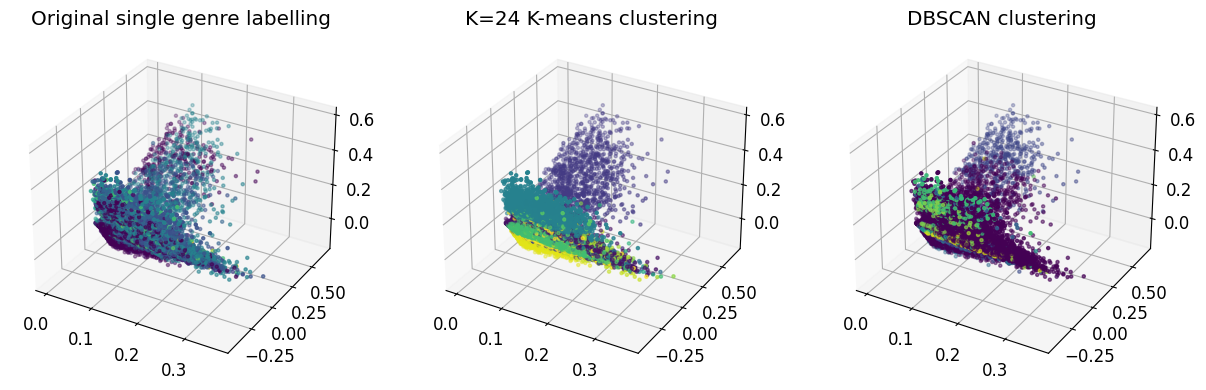

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(x, y, z, c=LabelEncoder().fit_transform(cluster_df['main_movie_genre'].values), marker='.')
ax.set_title('Original single genre labelling')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(x, y, z, c=k24_labels, marker='.')
ax.set_title('K=24 K-means clustering')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(x, y, z, c=dbscan_labels, marker='.')
ax.set_title('DBSCAN clustering')

In [ ]:
cluster_df['dbscan'] = dbscan_labels
cluster_df.head()

,conversation,movie_genres,main_movie_genre,dbscan
0,10 things i hate about you (1999)\nBIANCA: Can...,"['comedy', 'romance']",comedy,-1
1,10 things i hate about you (1999)\nBIANCA: You...,"['comedy', 'romance']",comedy,-1
2,"10 things i hate about you (1999)\nBIANCA: No,...","['comedy', 'romance']",comedy,-1
3,10 things i hate about you (1999)\nCAMERON: Wh...,"['comedy', 'romance']",comedy,-1
4,10 things i hate about you (1999)\nBIANCA: Gos...,"['comedy', 'romance']",comedy,-1


DBSCAN was the only clustering algorithm to test apart from K-means, because others like Spectral, Gaussian Mixture, and Agglomerative clustering used all memory available and take too long to converge.

In this sense, DBSCAN was able to identify 53 distinct clusters from the movie conversations, which is close to the original 24 distinct movie genres in the dataset. Moreover, the high completeness and low homogeneity illustrates that documents belonging to same movie genre are clustered together, but clusters are not pure because contain data points from other movie genres. Fortunately, this is the expected behavior since a movie dialogue can be classified with multiple movie genres simultaneously.

Finally, the 3D plot depicted that DBSCAN was able to learn the shape of the genre clusters more similarly to the original dataset using the main movie genre of the movie dialogue.

### Topic Modeling

Allows soft-clustering of conversations so that they can belong to multiple movie genres with certain probability (expected behavior as a movie can belong to multiple genres).

In [ ]:
topic_df = get_index_dataframe()[['conversation', 'movie_genres']]
topic_df.head()

,conversation,movie_genres
0,10 things i hate about you (1999)\nBIANCA: Can...,"['comedy', 'romance']"
1,10 things i hate about you (1999)\nBIANCA: You...,"['comedy', 'romance']"
2,"10 things i hate about you (1999)\nBIANCA: No,...","['comedy', 'romance']"
3,10 things i hate about you (1999)\nCAMERON: Wh...,"['comedy', 'romance']"
4,10 things i hate about you (1999)\nBIANCA: Gos...,"['comedy', 'romance']"


In [ ]:
# Split documents randomly into 70% train and 30% test
documents_train, documents_test, label_train, label_test = train_test_split(topic_df['conversation'].values, topic_df['movie_genres'].values, test_size=0.2)
print('No. training docs:', len(documents_train))
print('No. testing docs:', len(documents_test))

No. training docs: 66477
No. testing docs: 16620


#### Count document vectorization
- Without most and least frequent terms
- Without English stopwords
- 15,559 vocabulary size (smaller than TF-IDF)
- 18.17 average document (conversation) vocabulary size

In [ ]:
vectorizer = CountVectorizer(max_df=0.5, min_df=5, stop_words='english')
vector_documents_train = vectorizer.fit_transform(documents_train)
len(vector_documents_train.shape)

2

In [ ]:
vocab = vectorizer.get_feature_names_out()
print(f'Length of vocabulary: {len(vocab)}')
print()
print(f"Average document vocabulary size: {vector_documents.count_nonzero()/vector_documents.get_shape()[0]}")
print()
print('Sample vocabulary terms:')
print(sorted(random.sample(vocab.tolist(),100)))

Length of vocabulary: 15559

Average document vocabulary size: 18.166973536950792

Sample vocabulary terms:
['28', 'accepts', 'admired', 'alleged', 'arrange', 'aspect', 'attention', 'australia', 'azteca', 'balboa', 'barbie', 'barely', 'battalion', 'bleak', 'blink', 'bo', 'bobo', 'boeman', 'bree', 'burst', 'carla', 'cecile', 'connecticut', 'convinced', 'conway', 'cope', 'daisy', 'deadline', 'deeper', 'delongpre', 'demons', 'dewitt', 'dip', 'disorder', 'disregard', 'district', 'elliot', 'elliott', 'forget', 'friends', 'frozen', 'gilles', 'gum', 'hoax', 'honora', 'household', 'huntin', 'incriminating', 'indy', 'intelligent', 'irresistible', 'janine', 'joan', 'josephine', 'killed', 'knives', 'lafayette', 'lake', 'lent', 'mainly', 'manhunt', 'memos', 'messy', 'meyerling', 'mocked', 'month', 'necessarily', 'niagara', 'obliged', 'obregon', 'pierce', 'portable', 'practical', 'pregnant', 'present', 'proceeding', 'punish', 'puttin', 'quartet', 'revolutionary', 'rubbing', 'safely', 'saint', 'snat

#### Topic extraction using Latent Dirichlet Allocation (LDA)

- Identifies underlying topics by grouping words that frequently co-occur across documents

- Deals with polysemy, synonymy and short documents

In [ ]:
# Train LDA model
lda = LatentDirichletAllocation(n_components=len(distinct_genres), learning_method='online', max_iter=30)
lda.fit(vector_documents_train)

# Evaluate LDA model
vector_documents_test = vectorizer.transform(documents_test)
print(f'Perplexity: {lda.perplexity(vector_documents_test)}')

Perplexity: 4761.7143992065585


**Inspect most important terms learned for each topic**

In [ ]:
# Print most important terms for each topic
for i in range(len(lda.components_)):
  sorted_terms = lda.components_[i].argsort()[::-1]
  concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
  print(f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [home, doesn, rose, walk, matter, captain, carter, lee, mr, yes]
Topic 2:	 [2003, harry, tomorrow, 1993, forget, happened, ii, jason, lloyd, late]
Topic 3:	 [years, george, place, peter, 1992, 2000, man, theo, ago, james]
Topic 4:	 [house, michael, night, bad, max, used, come, ll, make, run]
Topic 5:	 [2001, dr, frank, dead, doctor, betty, president, body, buddy, party]
Topic 6:	 [mother, 2002, 2005, 1984, ship, movie, 1999, mac, barry, world]
Topic 7:	 [david, fucking, room, hey, start, did, somebody, blood, dog, jennifer]
Topic 8:	 [1979, face, 1998, chance, hate, gets, use, death, 1999, set]
Topic 9:	 [1996, jerry, eve, miss, mr, sleep, hi, town, louis, goes]
Topic 10:	 [people, things, did, god, lot, haven, oh, went, know, 1995]
Topic 11:	 [1994, boy, mary, world, ya, story, ll, thousand, gave, ma]
Topic 12:	 [don, know, just, ve, want, got, like, think, tell, didn]
Topic 13:	 [john, fine, 2000, guess, walter, mike, yeah, harold, ll, book]
Topic 14:	 [love, voice, minutes

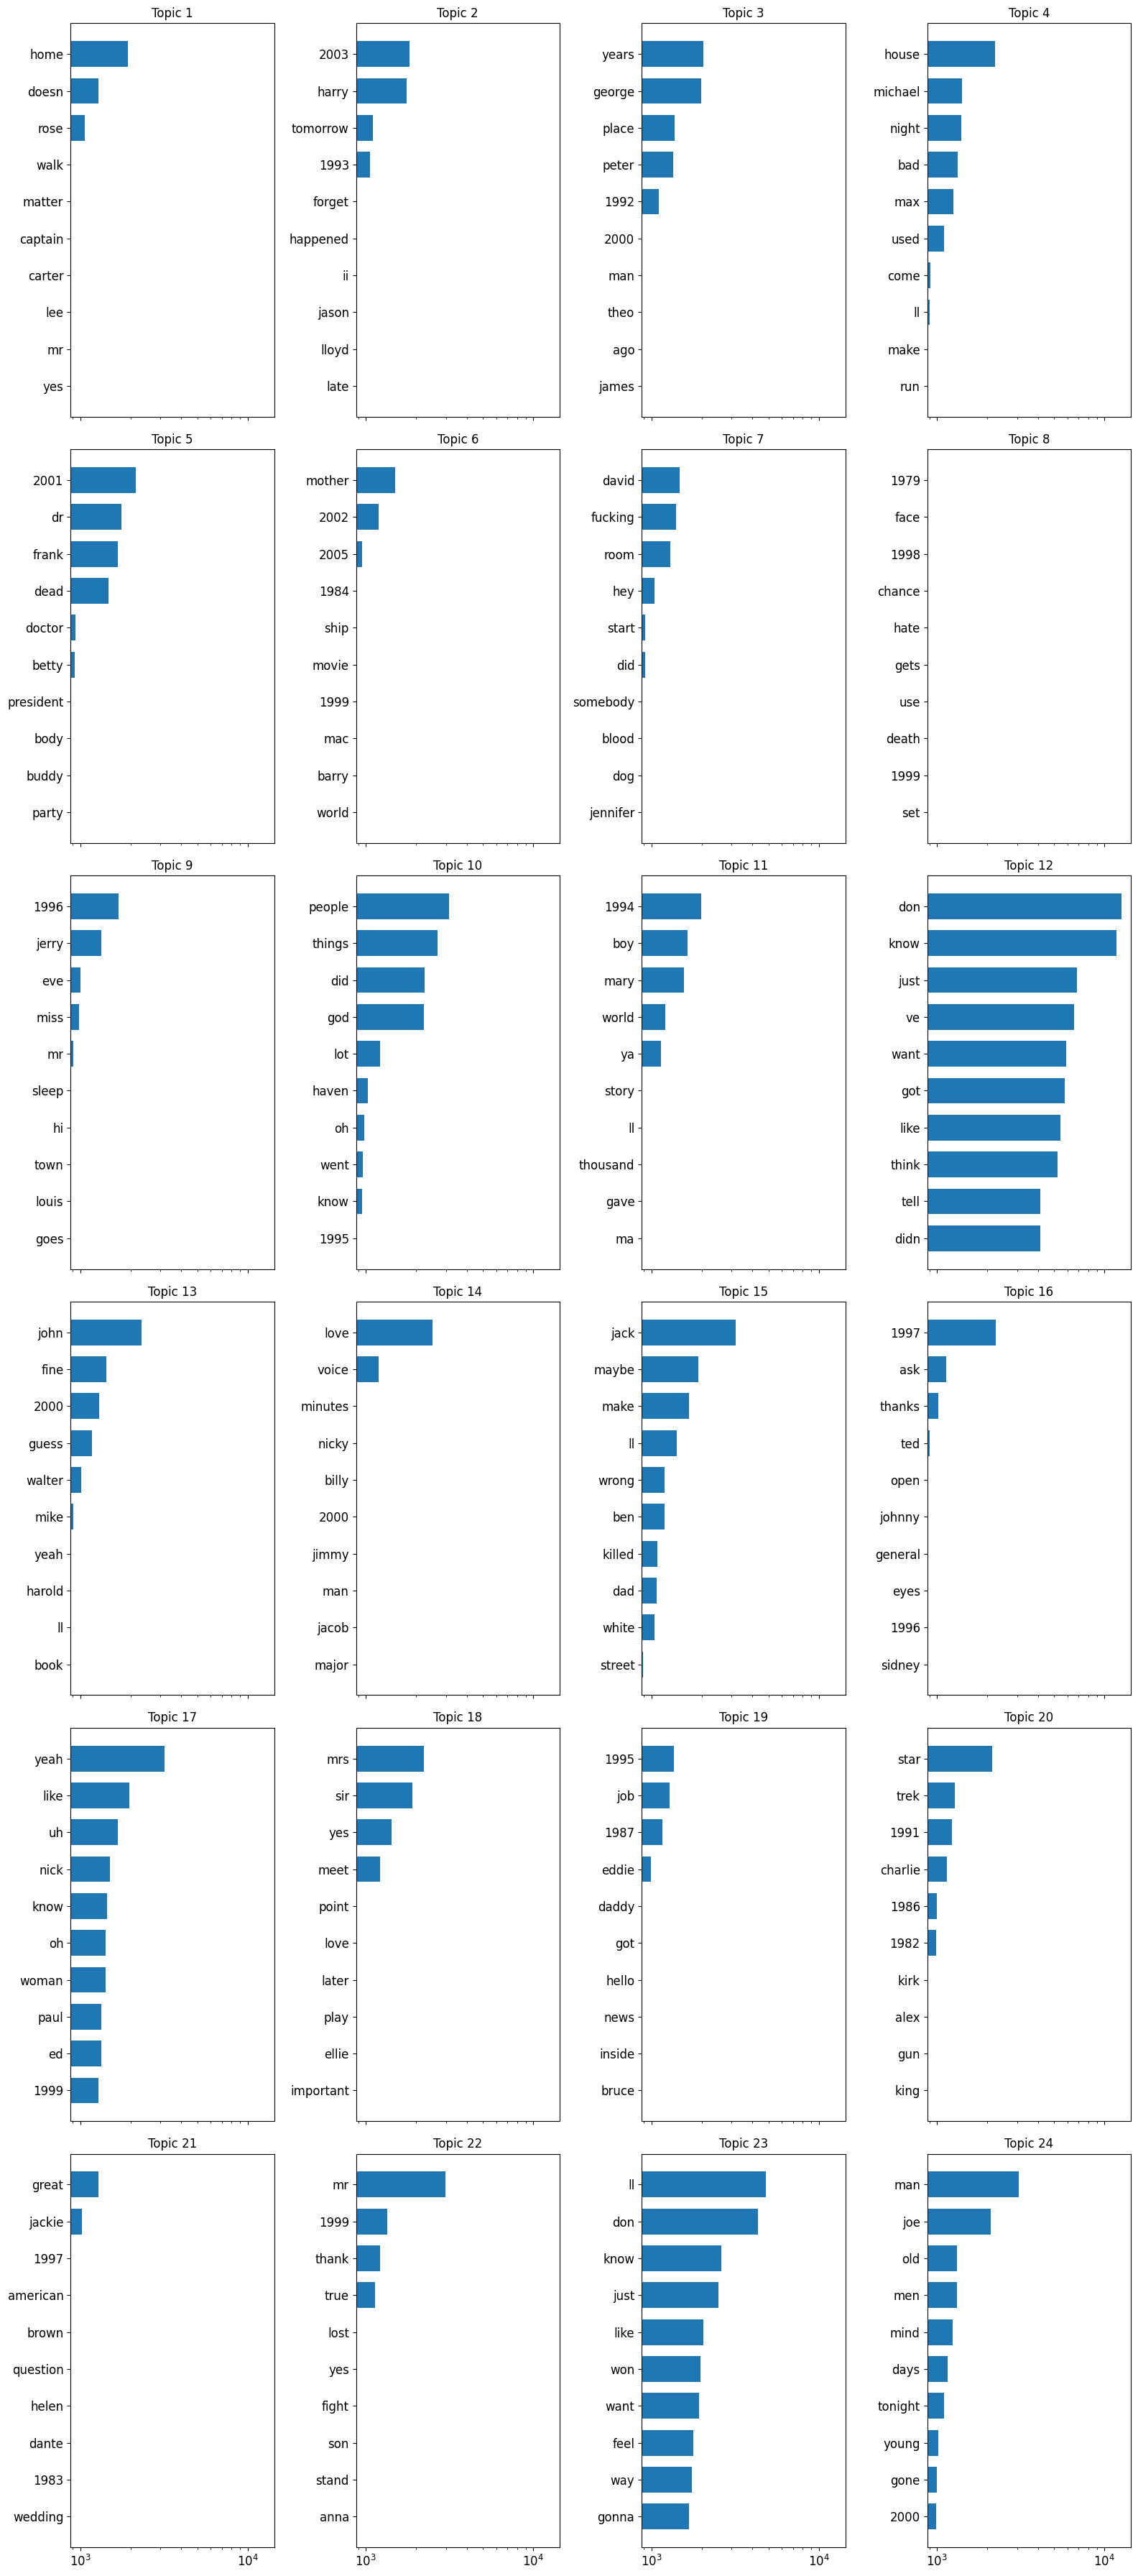

In [ ]:
# Prevalence of word in each topic
# Adapted from https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
num_words = 10
cols = 4
rows = int(len(lda.components_)/4)

fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 12})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

In the topic modeling with LDA context, the Perplexity metric indicates the level of "uncertainty" in the model's prediction result. Since the resulting 4,761 Perplexity value was high, suggests that the LDA model do not make good predictions and has poor fit on the data (not closely matching the actual distribution of words in the documents).

Additionally, the most important words in each topic either include movie-specific characters, dates and words, or English generic words (e.g. verbs, pronouns). Hence the topic modeling was not able to identify genres correctly according to the lexicon, but was able to recognize topics as movies or groups of movies with similar lexicon.

- Topic 5 might correspond to 2001 movies related to doctors and dead
- Topic 12 most important words are generic words
- Topic 14 might correspond to dialogues that involve characters and "love" word
- Topic 18 might correspond to dialogues where there is a meeting point involving male characters
- Topic 20 might correspind to Star Trek saga dialogues

**Visualizing topic representation learned compared to original movie genre**

Using t-distributed Stochastic Neighbor Embedding (t-SNE) dimensionality reduction technique

In [ ]:
tsne_embedding = TSNE(n_components=3).fit_transform(lda.transform(vector_documents_test))
tsne_embedding.shape

(16620, 3)

Text(0.5, 0.92, 'LDA topic modeling')

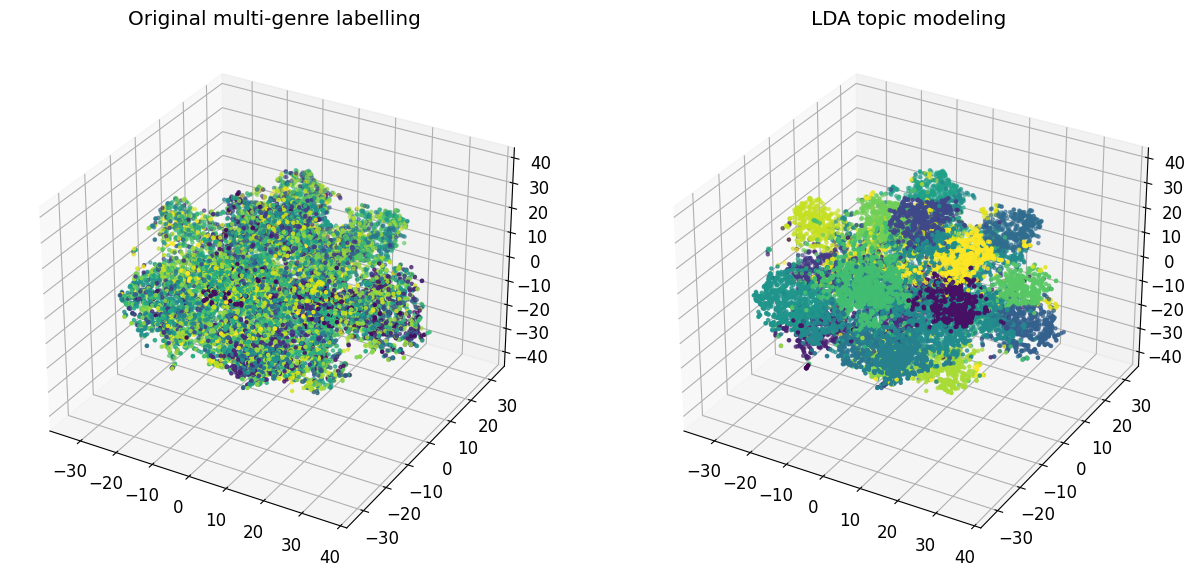

In [ ]:
[x, y, z] = np.transpose(tsne_embedding)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x, y, z, c=LabelEncoder().fit_transform(label_test), marker='.')
ax.set_title('Original multi-genre labelling')

freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_documents_test)]
ax = fig.add_subplot(122, projection='3d')
ax.scatter(x, y, z, c=freq_topic, marker='.')
ax.set_title('LDA topic modeling')


The 3D visualization confirms the topics learned do not correspond to the movie genres, but to movies and groups of movies with similar vocabulary, as noted previously.

**Inspect topic modeling results with test documents**

In [ ]:
rand_index = random.randint(0, len(documents_test)-1)
doc = documents_test[rand_index]
print(doc)
print(f'Genres: {label_test[rand_index]}')

sister act (1992)
CHRISTY: Hey, girls.
MARY PATRICK AND ROBERT: Hail, Mary.
CHRISTY: Jerusalem is a real drag.  Everybody hates me.
MARY PATRICK AND ROBERT: Oh-huh.
CHRISTY: People throw stones.  They call me names.  I mean, really.
MARY PATRICK AND ROBERT: Really.
CHRISTY: But -- wait.

Genres: ['comedy', 'crime', 'music']


In [ ]:
# Vectorize and transform using LDA to generate the topic distribution of the document
doc_vec = vectorizer.transform([doc])[0]
topic_vec = lda.transform(doc_vec)[0]
topic_vec

array([0.00119048, 0.03477583, 0.14293411, 0.03745541, 0.00119048,
       0.03035662, 0.0508686 , 0.00119048, 0.00119048, 0.05077552,
       0.14238462, 0.00119048, 0.17360426, 0.00119048, 0.00119048,
       0.03087542, 0.10283174, 0.11456013, 0.00119048, 0.00119048,
       0.00119048, 0.00119048, 0.00119048, 0.07429203])

In [ ]:
sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

for i in range(10):
  if sorted_prevalence[i] < .01: break # Get rid of topics with probability < 1%
  topic = sorted_topics[i]
  sorted_terms = np.flip(lda.components_[topic].argsort())
  print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

17.4% Topic 12: john fine 2000 guess walter mike yeah harold ll book
14.3% Topic 2: years george place peter 1992 2000 man theo ago james
14.2% Topic 10: 1994 boy mary world ya story ll thousand gave ma
11.5% Topic 17: mrs sir yes meet point love later play ellie important
10.3% Topic 16: yeah like uh nick know oh woman paul ed 1999
7.4% Topic 23: man joe old men mind days tonight young gone 2000
5.1% Topic 6: david fucking room hey start did somebody blood dog jennifer
5.1% Topic 9: people things did god lot haven oh went know 1995
3.7% Topic 3: house michael night bad max used come ll make run
3.5% Topic 1: 2003 harry tomorrow 1993 forget happened ii jason lloyd late


The most important words of the most-likely topics of the conversation generally do not match with the movie dialogue. However, the ones that match typically are the dialogue date or characters involved.

In general, the topic modeling did not performed as good as expected, and was not able to identify genres, but movies, characters and dates. The task could be accomplished better if we encode conversations semantically, and not lexically, to detemine a conversation genre.

### Learn Word Embeddings

- Using **Word2Vec** to capture semantic relationships and contextual **word** meanings specific to movie dialogues.
- Using **FastText to capture semantic relationships and context of **subwords** information, enhancing the understanding of language used in movie dialogues.








In [ ]:
def tokenize_to_embeddings(texts):
  '''
  Tokenizes a list of texts into a list of word tokens suitable for word embeddings training.
  1. Sentence tokenization: Splits each text into sentences.
  2. Text normalization: Converts all text to lowercase.
  3. Word tokenization: Splits each sentence into words.
  4. Punctuation removal: Removes punctuation tokens.
  params:
  - texts (list): List of text documents to be tokenized
  returns:
  - List of word tokens from all input texts
  '''
  tokenized_sentences = []
  for text in texts:
    text_sent = sent_tokenize(text)
    for sent in text_sent:
      sent = sent.strip().lower()
      tokenized_sentence = word_tokenize(sent)
      tokenized_sentence = [word for word in tokenized_sentence if word not in string.punctuation]
      if len(tokenized_sentence) > 1:
        tokenized_sentences.append(tokenized_sentence)
  return tokenized_sentences

**Tokenize all the sentences in the movie dialogue dataset**

In [ ]:
tokenized_sentences = tokenize_to_embeddings(dataset.get_utterance_texts_list())

for sentence in tokenized_sentences[:10]:
  print(sentence)

['they', 'do', 'not']
['they', 'do', 'to']
['i', 'hope', 'so']
['she', 'okay']
['let', "'s", 'go']
['okay', '--', 'you', "'re", 'gon', 'na', 'need', 'to', 'learn', 'how', 'to', 'lie']
['i', "'m", 'kidding']
['you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', '``', 'persona', "''"]
['and', 'you', 'do', "n't", 'know', 'how', 'to', 'quit']
['like', 'my', 'fear', 'of', 'wearing', 'pastels']


**Train Word2Vec (CBOW) and FastText models on movie dialogue sentences**

In [ ]:
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=80, window=3, min_count=5, workers=4) # Default CBOW
word2vec_model.save("word2vec_movie_dialogues.model")
print(f'Vocabulary size (word vectors learnt): {len(word2vec_model.wv)}')

Vocabulary size (word vectors learnt): 17217


In [ ]:
fasttext_model = FastText(sentences=tokenized_sentences, vector_size=80, window=3, min_count=5, workers=4)
fasttext_model.save("fasttext_movie_dialogues.model")
print(f'Vocabulary size (word vectors learnt): {len(fasttext_model.wv)}')

Vocabulary size (word vectors learnt): 17217


**Inspect resulting word embeddings**

In [ ]:
terms = ['love', 'jedi', 'crime', 'house', 'italy', 'night']

print('Word2Vec model')
for term in terms:
  print(f"Most similar terms to '{term}':")
  print(word2vec_model.wv.most_similar(term)) # cosine similarity between embeddings
  print()

Word2Vec model
Most similar terms to 'love':
[('hate', 0.6094528436660767), ('touch', 0.5766542553901672), ('fear', 0.5596014261245728), ('believe', 0.5470983386039734), ('trust', 0.519922137260437), ('interested', 0.46514302492141724), ('want', 0.4482937157154083), ('kiss', 0.4445796608924866), ('loved', 0.4430447220802307), ('admire', 0.4423809349536896)]

Most similar terms to 'jedi':
[('pirate', 0.8260606527328491), ('revolutionary', 0.8232774138450623), ('traitor', 0.8228535652160645), ('patriot', 0.8162568211555481), ('tribe', 0.8132510781288147), ('constant', 0.8121492862701416), ('rebel', 0.8112317323684692), ('scientist', 0.8095986247062683), ('psychologist', 0.8079434633255005), ('purely', 0.8072633743286133)]

Most similar terms to 'crime':
[('group', 0.7699291706085205), ('violation', 0.7515342235565186), ('lifetime', 0.7469171285629272), ('concept', 0.7430598139762878), ('weapon', 0.7387203574180603), ('event', 0.7379832863807678), ('drug', 0.735226035118103), ('series', 0

In [ ]:
print('FastText model')
for term in terms:
  print(f"Most similar terms to '{term}':")
  print(fasttext_model.wv.most_similar(term, topn=50)) # cosine similarity between embeddings
  print()

FastText model
Most similar terms to 'love':
[('glove', 0.9343709349632263), ("'love", 0.929676353931427), ('lovey', 0.8961154222488403), ('lovejoy', 0.8869109749794006), ('lovett', 0.8442078828811646), ('hate', 0.8214643597602844), ('loveless', 0.7958468198776245), ('lover', 0.786755383014679), ('loved', 0.7851050496101379), ('lovin', 0.7622032761573792), ('lovely', 0.7561379671096802), ('dove', 0.7541934251785278), ('loves', 0.7466384768486023), ('grieve', 0.7449122667312622), ('beloved', 0.7439382076263428), ('lovebirds', 0.740143358707428), ('despise', 0.7293805480003357), ('mistrust', 0.7254170775413513), ('demise', 0.7253193259239197), ('disapprove', 0.723627507686615), ('trusted', 0.7199541926383972), ('shakespeare', 0.7194563150405884), ('helmet', 0.7165948748588562), ('relieve', 0.7161913514137268), ('helpless', 0.7109931111335754), ('disrespect', 0.7101091146469116), ('distrust', 0.7096270322799683), ('believed', 0.7088397145271301), ('margaret', 0.7087052464485168), ('trust'

The trained word embedding models, Word2Vec and FastText, demonstrated distinct relationships between movie dialogue terms. Word2Vec was able to capture semantic meaning of words with respect to the movie dialogue corpus, while FastText showed a stronger lexical and phonetic influence of subwords, containing some semantics of the word.

**Word2Vec**
- "love" was closely associated with both positive and negative emotions contrary and related to love (e.g. hate, trust, fear, believe).
- "jedi" had connections to roles such as "pirate", "revolutionary", "tribe", and "patriot". This quites relates to what Star Wars Jedi are.
- "crime" according to the movie corpus involves concepts as "group" that does a "series" of "violation" and involves "weapon" and "drug".
- "house" was connected to compound words like "warehouse" and "household".
- "Italy" was mainly linked to adverbs (ending with 'ly') such as "potentially" and "romantically".
- "night" was related to temporal terms like "day", "weenend", and "week".

**FastText**
- "love" associated words like "glove", "beloved", "lover", and conjugations of the verb to love, together with some semantic relations to emotions such as "hate", "trust" and "betray".
- "jedi" was connected to names (e.g. malcolm, viola, macleod, valerie, joseph). Maybe the model related Star Wars jedi to people.
- "crime" had a mix of similar-sounding and related words like "prime" and "sublime".
- "house" was closely related to various types of buildings and rooms.
- "Italy" had geographical and historical associations.
- "night" was related to variations like "nightcap" and "nightclub", and to temporal terms like "day", "weenend", and "week".

Overall, Word2Vec was able to semantic relationships in the movie context, while FastText emphasizes phonetic similarities, reflecting distinct aspects of word associations in dialogues. Moreover, FastText allows to generate an embedding from words not seen in the original corpus by using subword embeddings.



In [ ]:
# Select random subset of terms and get their word vectors
sample = random.sample(list(word2vec_model.wv.key_to_index), 500)
word_vectors = word2vec_model.wv[sample]

# Fit and transform sample data to 3D using t-SNE model
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

# Plot word embeddings in 3D
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

The 3D plot of a sample of Word2Vec word embeddings of the movie dialogue dataset shows some interesting insights. Depeding on the random sample, the plot allows us to see how colors and animals have their own cluster in space, person names are sparsed all over the space, and that some semantically related words are close together.

## 2. Specific tasks

### Dataset paper *Chameleon Effect* Experiment

The Cornell Movie Dialogue Dataset is subject of the research paper titled "Chameleons in imagined conversations: A new approach to understanding coordination of linguistic style in dialogs," which explores the chameleon effect, where individuals nonconsciously adapt their use of function words to match their conversational partners.

Our goal is to replicate these findings by analyzing the dataset using Part-of-Speech (POS) tagging to detect stylistic convergence. Subsequently, we aim to leverage this understanding to develop a film dialogue generation chatbot that can produce more natural and contextually adaptive conversations.

**Chameleons in imagined conversations: A new approach to understanding coordination of linguistic style in dialogs**

https://www.cs.cornell.edu/~cristian/papers/chameleons.pdf

The paper explores the nonconscious coordination of humans to adapt to each other's use of function words, known as the chameleon effect, and how this is influenced by social status and gender roles. This behavior is partly innate due to evolutionary pressures that foster relationships, serving as a social strategy to gain approval and enhance comprehension.

**Key Research Question:**
The paper investigates whether scripted movie dialogues exhibit real-life stylistic convergence, where scriptwriters nonconsciously adjust respondents' replies to match the initiator's lexical choices.

**Methodology:**
- Analyzed the Cornell Movie Dialogue Dataset.
- Examined 9 LIWC-derived categories of stylistic features (earticles, auxiliary verbs, conjunctions, high-frequency adverbs impersonal pronouns, negations, personal pronouns, prepositions, and quantifiers).
- Measured convergence based on how one speaker's use of a feature triggers its use in the respondent's reply.
- Studied the effects of gender, narrative importance, and hostility.

**Results:**
- Found statistically significant convergence in all stylistic categories, demonstrating the chameleon effect.
- Showed that language coordination is deeply ingrained in conversational behavior.
- Females were found to be more influential than males in this coordination.
- Male characters adapted less in same-gender interactions (might be biased due to gender imbalance in the data).
- Lead characters converged more to second-billed characters than vice versa.

**Implications:**
Understanding this effect can improve human-computer interaction and aid in the construction of natural-language generation systems. It also has potential benefits for enhancing communication in organizational contexts, psychotherapy, care of the mentally disabled, and police-community interactions, ultimately improving communication between humans and between humans and computers.








In [ ]:
def retrieve_all_conversation_between_pairs(base_path):
  '''
  Retrieve all conversations between character pairs from the movie_conversations.txt file (faster than using data structure).
  params:
  - base_path (str): The base path where the dataset files are located
  returns:
  - list: List of all conversations between character pairs, where each conversation is a list of utterance IDs.
  '''
  conversations = []
  with open(os.path.join(base_path, "movie_conversations.txt"), "r", encoding="iso-8859-1") as file:
    char1_id = 'u'
    char2_id = 'u'
    temp = []
    for line in file:
      parts = [part.strip() for part in line.split("+++$+++")]
      # If character changes in text file
      if char1_id != parts[0] or char2_id != parts[1]:
        if len(temp) > 0: conversations.append(temp)
        char1_id = parts[0]
        char2_id = parts[1]
        temp = []
      temp.append(ast.literal_eval(parts[3]))
  return conversations

In [ ]:
def probs_conversations(group_conversations, stylistic_fam_pos):
  '''
  Calculate the probabilities of stylistic features manifesting in conversations.
  params:
  - group_conversations (list): List of grouped conversations, where each conversation is a list of utterance IDs.
  - stylistic_fam_pos (list): List of Part-of-Speech (PoS) tags representing a stylistic family.
  returns:
  - prob_both_manifest (float): Probability that both the utterance and its reply manifest the stylistic family.
  - prob_reply_manifest (float): Probability that the reply manifests the stylistic family.
  '''
  utt = 0
  utt_manifest = 0
  reply_manifest_to_utt_manifest = 0
  reply_manifest = 0

  for conv in group_conversations:
    for i in range(len(conv)-1):
      # Retrieve utterance and reply
      utterance = dataset.utterances[conv[i]]['text']
      reply = dataset.utterances[conv[i+1]]['text']

      # Generate PoS tags of utterance and reply
      utterance_pos = pos_tag(word_tokenize(utterance))
      reply_pos = pos_tag(word_tokenize(reply))

      # Detemine if utterance and reply manifest the stylistic family
      do_utterance_manifest = 0 < sum([1 if x[1] in stylistic_fam_pos else 0 for x in utterance_pos])
      do_reply_manifest = 0 < sum([1 if x[1] in stylistic_fam_pos else 0 for x in reply_pos])

      # Update counts
      utt += 1
      if do_reply_manifest: reply_manifest +=1
      if do_utterance_manifest:
        utt_manifest += 1
        if do_reply_manifest:
          reply_manifest_to_utt_manifest += 1

  prob_both_manifest = reply_manifest_to_utt_manifest/utt_manifest if utt_manifest > 0 else 0
  prob_reply_manifest = reply_manifest/utt if utt > 0 else 0

  return prob_both_manifest, prob_reply_manifest

**Chameleon Effect (coordination) linguistic experiment**

In [ ]:
# Dictionary for the Chameleon Effect linguistic experiment
chameleon_experiment = {
    'Adverb' : {
        'pos_tags': ['RB', 'RBR', 'RBS'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Article' : {
        'pos_tags': ['DT'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Aux_Verb' : {
        'pos_tags': ['MD'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Conjunction' : {
        'pos_tags': ['CC', 'IN'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Indef_Pronoun' : {
        'pos_tags': ['NN'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Pers_Pronoun' : {
        'pos_tags': ['PRP'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Preposition' : {
        'pos_tags': ['IN'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Quantifier' : {
        'pos_tags': ['JJ'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    }
}

In [ ]:
def chameleon_effect_probs(group_conversation, stylistic_fam_pos, prob_both_manifest, prob_reply_manifest):
  '''
  Calculate and append the probabilities of stylistic features manifesting in conversations for the Chameleon Effect.
  params:
  - group_conversation (list): List of grouped conversations, where each conversation is a list of utterance IDs
  - stylistic_fam_pos (list): List of Part-of-Speech (PoS) tags representing a stylistic family
  - prob_both_manifest (list): List to store probabilities that both the utterance and its reply manifest the stylistic family
  - prob_reply_manifest (list): List to store probabilities that the reply manifests the stylistic family

  returns:
  - prob_both_manifest (list): Updated list of probabilities that both the utterance and its reply manifest the stylistic family
  - prob_reply_manifest (list): Updated list of probabilities that the reply manifests the stylistic family
  '''
  for group in group_conversation:
    cond_prob, prob_manif = probs_conversations(group, stylistic_fam_pos)
    prob_both_manifest.append(cond_prob)
    prob_reply_manifest.append(prob_manif)

  return prob_both_manifest, prob_reply_manifest

**1. Retrieve all ordered pair of characters (A;B) dialogues**

In [ ]:
group_conversation = retrieve_all_conversation_between_pairs(DATASET_FOLDER)

**2. For all family features, estimate equation (1) Danescu-Niculescu-Mizil et al. (2011)**

$Conv_{A,B}(t) = P(b^t_a=1|a^t=1)-P(b^t_a=1)$

- $P(b^t_a=1|a^t=1) \approx$ fraction of *B* replies to *t*-manifesting *A* utterances that themselves exhibit *t*
- $P(b^t_a=1) \approx$ fraction of all replies of *B* to *A* that exhibit *t*

In [ ]:
for val in chameleon_experiment.values():
  chameleon_effect_probs(group_conversation, val['pos_tags'], val['prob_both_manifest'], val['prob_reply_manifest'])

# Save experiment dictionary (PoS tagging takes a lot of time)
with open('chameleon_experiment.pkl', 'wb') as fp:
    pickle.dump(chameleon_experiment, fp)

In [ ]:
# Retrieve experiment dictionary
with open('chameleon_experiment.pkl', 'rb') as fp:
  chameleon_experiment = pickle.load(fp)

**3. Paired t-test on probabilities differences for each linguistic family feature of the experiment**

In [ ]:
for k,v in chameleon_experiment.items():
  print('-'*100)
  print(k,':')
  print('Average P(b=1|a=1):', np.mean(v['prob_both_manifest']))
  print('Average P(b=1):', np.mean(v['prob_reply_manifest']))
  ttest = ttest_ind(v['prob_both_manifest'], v['prob_reply_manifest'])
  print(f'Statistical difference: {ttest[1]<0.01} ({ttest[1]} p-value)')

----------------------------------------------------------------------------------------------------
Adverb :
Average P(b=1|a=1): 0.44387262203956995
Average P(b=1): 0.46643373729771964
Statistical difference: True (3.3849405441601835e-12 p-value)
----------------------------------------------------------------------------------------------------
Article :
Average P(b=1|a=1): 0.47671039103899915
Average P(b=1): 0.5023139933981687
Statistical difference: True (6.223510938571436e-16 p-value)
----------------------------------------------------------------------------------------------------
Aux_Verb :
Average P(b=1|a=1): 0.18364319585500544
Average P(b=1): 0.19833472230654528
Statistical difference: True (6.387450846213957e-07 p-value)
----------------------------------------------------------------------------------------------------
Conjunction :
Average P(b=1|a=1): 0.46211358304578287
Average P(b=1): 0.49556470168485484
Statistical difference: True (1.087873179215389e-24 p-value)
----

**4. Plot convergence for each family showing the difference between the
means of probabilities**

In [ ]:
def plot_chameleon_experiment(data):
  '''
  Plot the probabilities of stylistic features manifesting in conversations for the Chameleon Experiment.
  params:
  - data (dict): Dictionary containing experiment data, where keys are stylistic feature categories and values are dictionaries with probabilities
  '''
  labels = list(data.keys())
  prob_both_manifest = [np.mean(data[key]['prob_both_manifest']) for key in labels]
  prob_reply_manifest = [np.mean(data[key]['prob_reply_manifest']) for key in labels]

  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots(figsize=(10, 6))
  rects1 = ax.bar(x - width/2, prob_both_manifest, width, label='Prob Both Manifest')
  rects2 = ax.bar(x + width/2, prob_reply_manifest, width, label='Prob Reply Manifest')

  # Add labels, title and custom x-axis tick labels
  ax.set_ylabel('Probabilities')
  ax.set_title('Chameleon Experiment Probabilities by POS Tag Category')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.tick_params(axis='x', labelsize=10)
  ax.legend()

  # Add data labels on top of the bars
  def add_labels(rects):
    for rect in rects:
      height = rect.get_height()
      ax.annotate(f'{height:.2f}',
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')

  add_labels(rects1)
  add_labels(rects2)

  fig.tight_layout()

  plt.show()

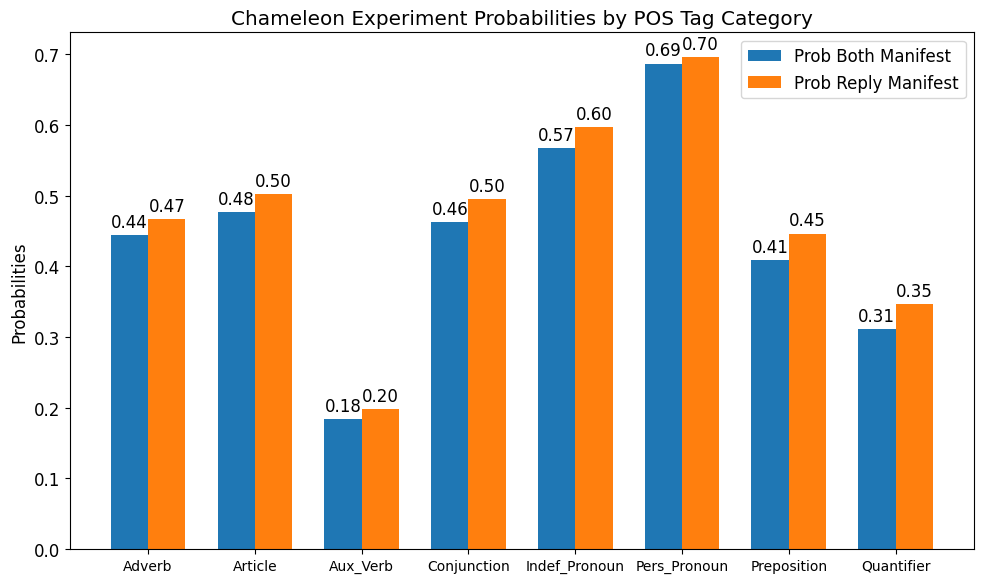

In [ ]:
plot_chameleon_experiment(chameleon_experiment)

As depicted in the results, across the various linguistic families (adverbs, articles, auxiliary verbs, conjunctions, indefinite pronouns, personal pronouns, prepositions, and quantifiers), there's a clear trend of higher probabilities for both the utterance and its reply manifesting the stylistic features when compared to the overall probability of manifestation. These differences are statistically significant, as indicated by the p-values obtained from the analysis. This suggests a strong tendency for conversational partners to adapt their linguistic style to match each other's, emphasizing the presence of the Chameleon Effect in scripted movie dialogues as stated in the paper (Danescu-Niculescu-Mizil et al., 2011).

### Film Dialog Generation

### Prediction of Metadata for specific dialog

## 3. Extensions